# Gaussian Process Regression

This lab is designed to introduce Gaussian processes in a practical way, illustrating the concepts introduced in the lecture. The key aspects of Gaussian process regression are covered: the covariance function (aka kernels); sampling a Gaussian process; and the regression model. The notebook uses [GPyTorch](https://gpytorch.ai/).

The level of this notebook is aimed at introductory. It covers a wide range of basic GP concepts. There are seven exercises to complete, the difficulty of which varies, but you should aim to complete all during the lab session.

## 1. Getting started

First, we need to setup our notebook with the libraries we are going to use. We will use `numpy` for maths functionality, `pyplot` for plotting, and `gpytorch` for Gaussian processes.

In [2]:
# Install prerequisite packages
!pip install -q gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import copy

import torch
# we use high precision in this lab
torch.set_default_dtype(torch.float64)

# GPyTorch: Gaussian processes library
import gpytorch
from gpytorch.means import ZeroMean, LinearMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ExactGP
from gpytorch.kernels import (
    Kernel, ScaleKernel, RBFKernel, MaternKernel, CosineKernel, LinearKernel, PeriodicKernel, ConstantKernel
)
from gpytorch.distributions import MultivariateNormal

The documentation for `gpytorch` is available at [gpytorch.ai](https://gpytorch.ai/). We will be using gpytorch to define our kernels, and regression.

### Covariance functions, aka kernels

We will define a covariance function, from hereon referred to as a kernel, using `gpytorch`. The most commonly used kernel in machine learning is the Gaussian-form radial basis function (RBF) kernel. It is also commonly referred to as the exponentiated quadratic or squared exponential kernel &ndash; all are equivalent.

The definition of the (1-dimensional) RBF kernel has a Gaussian-form, defined as:

$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$

It has two parameters, described as the variance, $\sigma^2$ and the lengthscale $\mathscr{l}$.

In `gpytorch`, we define our kernels using the input dimension, in the simplest case `ard_num_dims=1` for 1-dimensional regression. `RBFKernel` does not have an `outputscale` (`variance`) parameter. To add a scaling parameter,
decorate this kernel with a class:`gpytorch.kernels.ScaleKernel`. We explicitly define the `outputscale` and `lengthscale` parameters with value 1.0.

In [4]:
# Create a 1-D RBF kernel
k = ScaleKernel(RBFKernel(ard_num_dims=1))

# Set variance and lengthscale both with value 1.0
# Option1: use initialize function
k.initialize(**{'outputscale': 1.0, 'base_kernel.lengthscale': 1.0})

# Option2: directly assigning values
k.outputscale = 1.0
k.base_kernel.lengthscale = 1.0

In [5]:
gpytorch.__version__

'1.14'

In [7]:
kdummy = ScaleKernel(RBFKernel(ard_num_dims=1))
kdummy

ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

In [9]:
k.outputscale

tensor(1., grad_fn=<SoftplusBackward0>)

In [12]:
k.base_kernel.lengthscale

tensor([[1.]], grad_fn=<SoftplusBackward0>)

In [10]:
kdummy.outputscale

tensor(0.6931, grad_fn=<SoftplusBackward0>)

### Visualising the kernel

We can visualise our kernel in a few different ways. We can plot the _shape_ of the kernel by plotting $k(x,0)$ over some sample space $x$ which, looking at the equation above, clearly has a Gaussian shape. This describes the covariance between each sample location and $0$.

Alternatively, we can construct a full covariance matrix, $\mathbf{K}_{xx} \triangleq k(x,x')$ with samples $x = x'$. The resulting GP prior is a multivariate normal distribution over the space of samples $x$: $\mathscr{N}(\mathbf{0}, \mathbf{K}_{xx})$. It should be evident then that the elements of the matrix represents the covariance between respective points in $x$ and $x'$, and that it is exactly $\sigma^2[=1]$ in the diagonal.

We can show this using `pyplot` to plot the vector $k(x,0)$ and the matrix $k(x,x')$ using `k(`$\cdot$ `,` $\cdot$`)`:

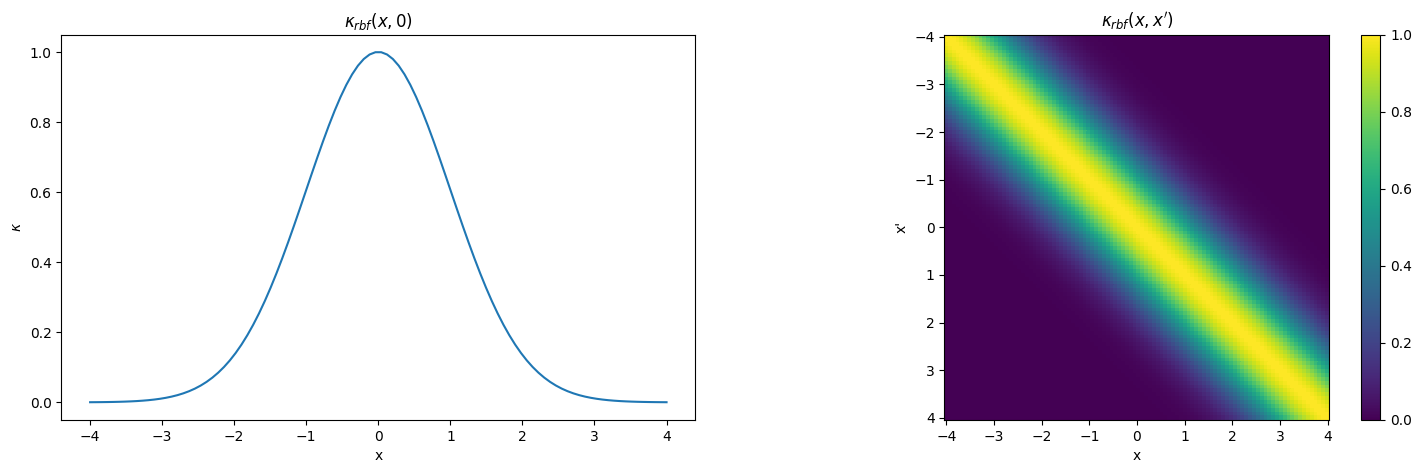

In [13]:
# Our sample space: 100 samples in the interval [-4,4]
X = torch.linspace(-4.0, 4.0, 100)[:, None]

# Set up the plotting environment
plt.figure(figsize=(18,5))

# ==== k(x,0)

plt.subplot(121) # left plot

# First, sample kernel at x' = 0
with torch.no_grad():
  K = k(X,torch.tensor([[0.]])) # k(x,0)

# Plot covariance vector
plt.plot(X, K)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.title("$\kappa_{rbf}(x,0)$")

# ==== k(x,x')

plt.subplot(122) # right plot

# The kernel takes two inputs, and outputs the covariance between each respective point in the two inputs
with torch.no_grad():
  K = k(X,X).numpy()

# Convert X to a NumPy array for compatibility with pcolor
X_np = X.numpy()

# Plot the covariance of the sample space
plt.pcolor(X_np.T, X_np, K)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("$\kappa_{rbf}(x,x')$");

## Setting the kernel parameters

Looking at the above definition of the RBF kernel, we can see that the parameters, i.e. variance and lengthscale, control the shape of the covariance function and therefore the value of the covariance between points $x$ and $x'$.

We can access the value of the kernel parameters in `gpytorch` and manually set them by calling `k.outputscale` or `k.base_kernel.lengthscale` for the RBF kernel. The following example demonstrates how the value of the lengthscale affects the RBF kernel:

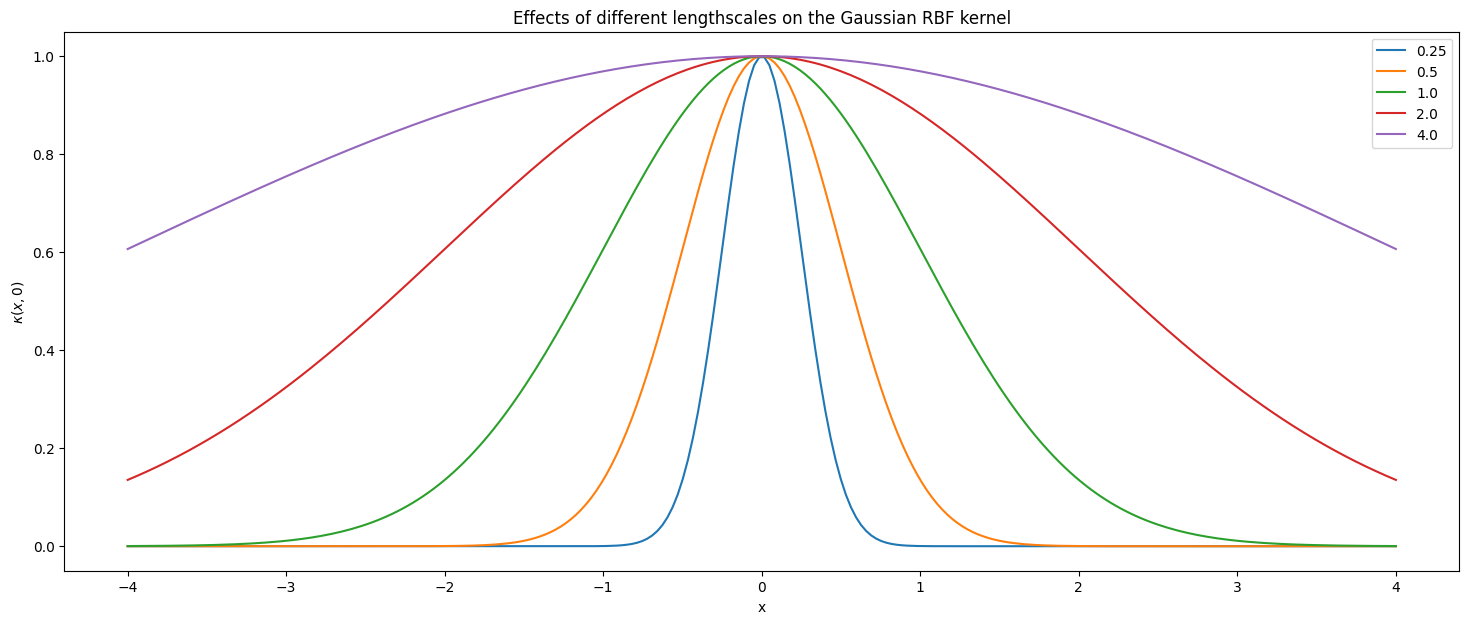

In [19]:
X = torch.linspace(-4.0, 4.0, 250)[:, None]  # we use more samples to get a smoother plot at low lengthscales

k = ScaleKernel(RBFKernel(ard_num_dims=1))
k.outputscale = 1.0

# Set up the plotting environment
plt.figure(figsize=(18, 7))

# Set up our list of different lengthscales
ls = [0.25, 0.5, 1., 2., 4.]

# Loop over the lengthscale values
for l in ls:
    # Set the lengthscale to be l
    k.base_kernel.lengthscale = l
    # Calculate the new covariance function at k(x,0)
    with torch.no_grad():
      C = k(X, torch.tensor([[0.]]))
    # Plot the resulting covariance vector
    plt.plot(X,C)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa(x,0)$")
plt.title("Effects of different lengthscales on the Gaussian RBF kernel")
plt.legend(labels=ls);

### Exercise 1

(a) What is the effect of the lengthscale parameter on the covariance function?

(b) Change the code used above to plot the covariance function showing the effects of the variance on the covariance function. Comment on the effect.

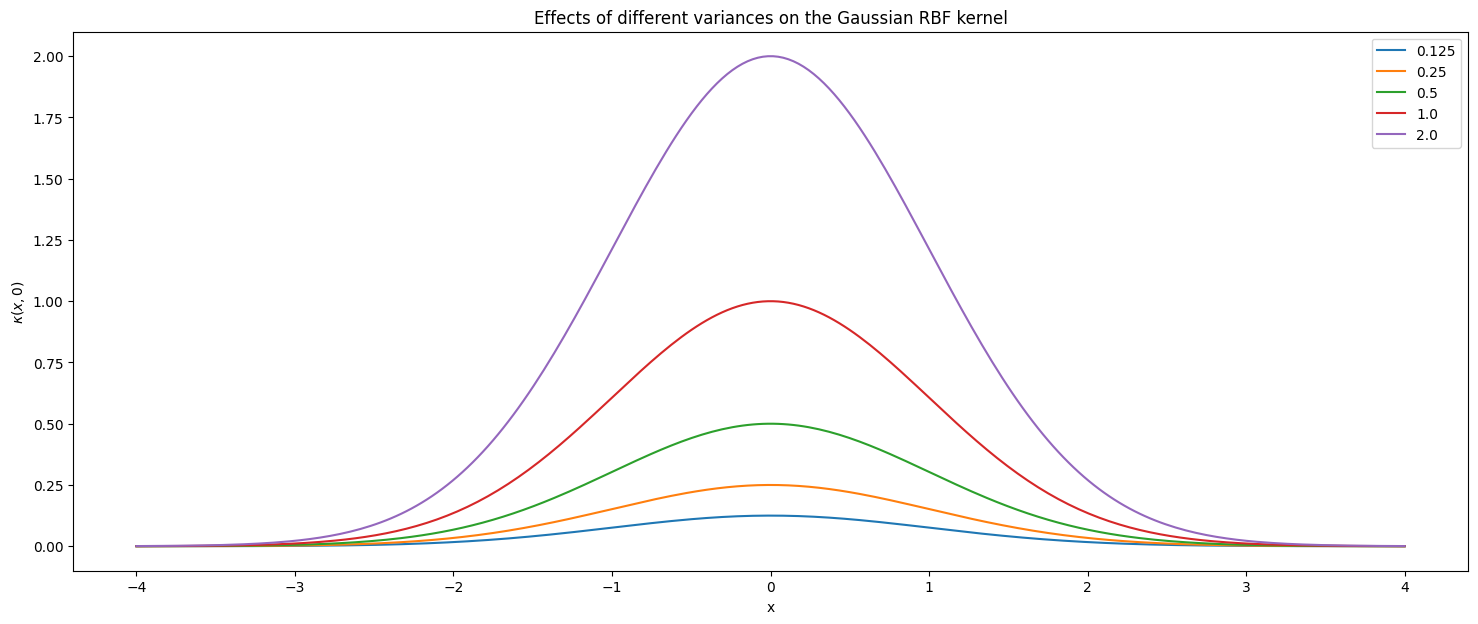

In [23]:
X = torch.linspace(-4.0, 4.0, 250)[:, None]  # we use more samples to get a smoother plot at low lengthscales

k = ScaleKernel(RBFKernel(ard_num_dims=1))
k.base_kernel.lengthscale = 1.

# Set up the plotting environment
plt.figure(figsize=(18, 7))

# Set up our list of different variances
vs = [0.125,0.25, 0.5, 1., 2.,]

# Loop over the lengthscale values
for v in vs:
    # Set the variance to be v
    k.outputscale = v
    # Calculate the new covariance function at k(x,0)
    with torch.no_grad():
      C = k(X, torch.tensor([[0.]]))
    # Plot the resulting covariance vector
    plt.plot(X,C)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa(x,0)$")
plt.title("Effects of different variances on the Gaussian RBF kernel")
plt.legend(labels=vs);

## 2. Types of covariance function

There are many different covariance functions already implemented in `GPyTorch`. Aside from the `RBF` kernel, there are others such as the following:
- `Matern` (including $\nu=\frac{1}{2}, \frac{3}{2},\frac{5}{2}$)
- `Linear`
- `Cosine`
- `Constant`
- `Periodic`
- `Exponential` <u>(included in `MaternKernel`)</u>
- `Matern32` <u>(included in `MaternKernel`)</u>
- `Matern52` <u>(included in `MaternKernel`)</u>
- `Brownian` <u>(not included in gpytorch)</u>
- `Bias` <u>(i.e., `ConstantKernel`)</u>
- `StdPeriodic` <u>(i.e., `PeriodicKernel`)</u>

Note: when defining these, all are preceded by <u>`gpytorch.kernels.` and followed by `Kernel`, or you can use relative import.</u> The following are some examples of the [Matérn 5/2](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function) and Cosine kernels, compared with the RBF kernel:

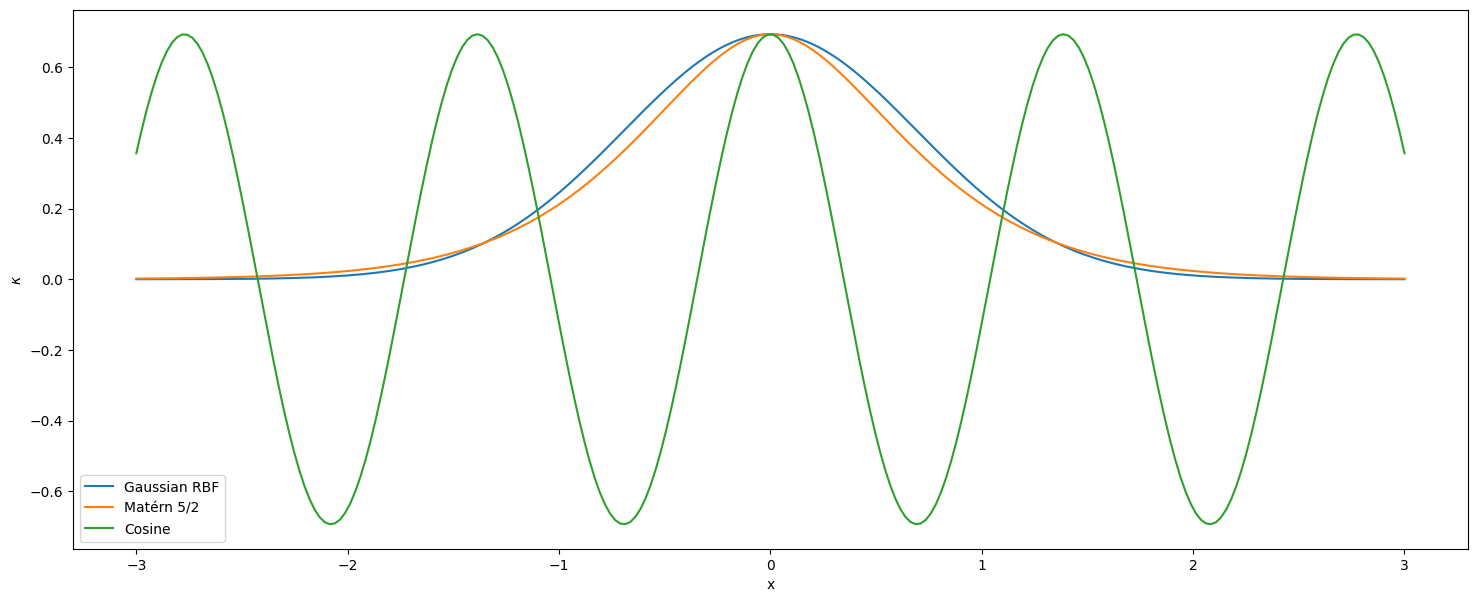

In [28]:
# Our sample space : 250 samples in the interval [-3, 3]
X = torch.linspace(-3, 3, 250)[:, None]

# scaled RBF kernel
k_R = ScaleKernel(RBFKernel())
C_R = k_R(X, torch.tensor([[0.]]))

# Matern 5/2
k_M = ScaleKernel(MaternKernel(nu=2.5))   # smoothness parameter = 5/2
C_M = k_M(X, torch.tensor([[0.]]))

# Cosine
k_C = ScaleKernel(CosineKernel())
C_C = k_C(X, torch.tensor([[0.]]))

with torch.no_grad():
  plt.figure(figsize=(18,7))
  plt.plot(X, C_R, X, C_M, X, C_C);
  plt.xlabel("x"), plt.ylabel("$\kappa$")
  plt.legend(labels=["Gaussian RBF", "Matérn 5/2", "Cosine"]);

In [27]:
print(k_R.outputscale)
print(k_R.base_kernel.lengthscale)

tensor(0.6931, grad_fn=<SoftplusBackward0>)
tensor([[0.6931]], grad_fn=<SoftplusBackward0>)


Not every kernel has the same set of parameters. Some kernels are not parameterised by a lengthscale, for example, like the `Linear` kernel which only has a list of variances corresponding to each linear component

In [30]:
def show_params(kernel):
  """ Printing utility to show parameters of a GP """
  for param_name, param, constraint in kernel.named_parameters_and_constraints():
    actual_value = constraint.transform(param)
    print(f'Parameter name: {param_name},  raw_value = {param.item():.5f},  constraint: {constraint}, actual_value: {actual_value.item():.5f}')

k_L = LinearKernel()
show_params(k_L)

Parameter name: raw_variance,  raw_value = 0.00000,  constraint: Positive(), actual_value: 0.69315


In [31]:
show_params(k_R)

Parameter name: raw_outputscale,  raw_value = 0.00000,  constraint: Positive(), actual_value: 0.69315
Parameter name: base_kernel.raw_lengthscale,  raw_value = 0.00000,  constraint: Positive(), actual_value: 0.69315


In [32]:
show_params(k_M)

Parameter name: raw_outputscale,  raw_value = 0.00000,  constraint: Positive(), actual_value: 0.69315
Parameter name: base_kernel.raw_lengthscale,  raw_value = 0.00000,  constraint: Positive(), actual_value: 0.69315


In [33]:
show_params(k_C)

Parameter name: raw_outputscale,  raw_value = 0.00000,  constraint: Positive(), actual_value: 0.69315
Parameter name: base_kernel.raw_period_length,  raw_value = 0.00000,  constraint: Positive(), actual_value: 0.69315


Likewise, not every kernel is stationary. In the case of the Gaussian RBF, or Matérn kernels, the kernel can be written $\kappa(x,x') = f(x-x')$, however this is not true for, e.g., the Brownian motion covariance function, which is defined as $k(x,x') = \min(x,x')$

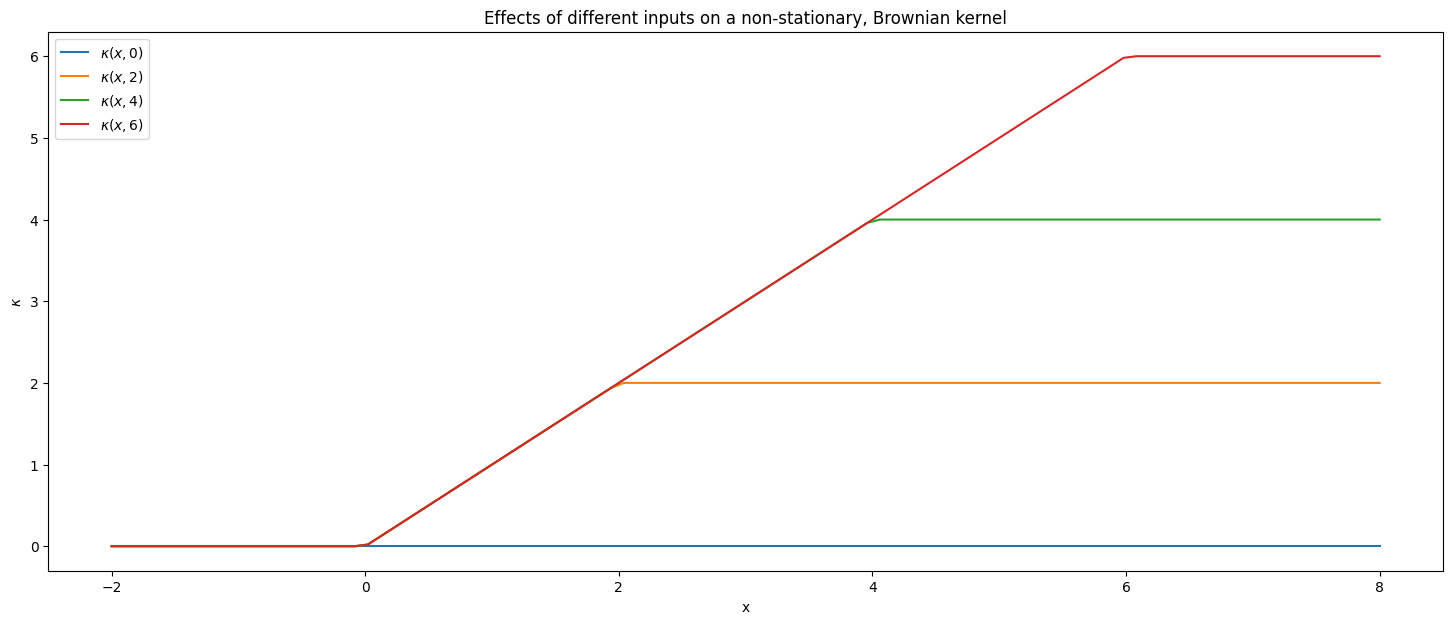

In [ ]:
# Note that the Brownian kernel is defined:
#   k = min(abs(x),abs(x')) if sgn(x) = sgn(x')
#   k = 0 if sgn(x) ≠ sgn(x')

# We define our Brownian kernel
class BrownianKernel(Kernel):
  has_lengthscale = False
  def __init__(self, **kwargs):
    super(BrownianKernel, self).__init__(**kwargs)

  def forward(self, x1, x2, diag=False, **params):
    x2_ = x2.T
    res = torch.where(x1.sign() == x2_.sign(), torch.fmin(x1.abs(), x2_.abs()), 0.)
    if diag:
      return res.squeeze(-1)
    return res

# Our sample space : 100 samples in the interval [-2,8]
X = torch.linspace(-2., 8., 100)[:,None]

k_B = BrownianKernel()

with torch.no_grad():
  plt.figure(figsize=(18,7))

  x_s = [0., 2., 4., 6.] # values of x'
  # Loop through values of x'
  for x_ in x_s:
    # Evaluate kernel at k(x,x')
    K_B = k_B(X, torch.tensor([[x_]]))
    # Plot covariance vector
    plt.plot(X, K_B)

  # Annotate plot
  plt.xlabel("x"), plt.ylabel("$\kappa$")
  plt.title("Effects of different inputs on a non-stationary, Brownian kernel")
  plt.legend(labels=["$\kappa(x,0)$", "$\kappa(x,2)$", "$\kappa(x,4)$", "$\kappa(x,6)$"]);

## 3. Combining covariance functions

### Exercise 2

(a) A matrix, $\mathbf{K}$, is positive semi-definite if the matrix inner product is greater than or equal to zero, $\mathbf{x}^\text{T}\mathbf{K}\mathbf{x} \geq 0$, _regardless of the values in $\mathbf{x}$_. Given this, it should be easy to see that the sum of two positive semi-definite matrices is also positive semi-definite. In the context of Gaussian processes, this is the sum of two covariance functions. What does this mean from a modelling perspective?

(b) What about the element-wise product of two covariance functions? If we define $k(\mathbf{x}, \mathbf{x}') = k_1(\mathbf{x},\mathbf{x}')k_2(\mathbf{x},\mathbf{x}')$, then is $k(\mathbf{x},\mathbf{x}')$ a valid covariance function?

### Combining kernels in gpytorch

We can easily combine kernels using `gpytorch` using the `+` and `*` operators, respectively denoting addition and product of kernels.

#### Summing kernels
An example of adding kernels is shown here. We create a new kernel that is the `sum` of an RBF and a Matern 5/2 kernel.

In [ ]:
# Create the first kernel: a 1-D RBF with variance 1.0 and lengthscale 2.0
k_R = ScaleKernel(RBFKernel(ard_num_dims=1))
k_R.initialize(**{'outputscale': 1.0, 'base_kernel.lengthscale': 2.0})

# Create the second kernel: a 1-D Matern52 with variance 2.0 and lengthscale 4.0
k_M = ScaleKernel(MaternKernel(nu=2.5))
k_M.initialize(**{'outputscale': 2.0, 'base_kernel.lengthscale': 4.0})

# Add the kernels together
k_sum = k_R + k_M
# Preview the properties of the composite kernel
show_params(k_sum)

Parameter name: kernels.0.raw_outputscale,  raw_value = 0.54132,  constraint: Positive(), actual_value: 1.00000
Parameter name: kernels.0.base_kernel.raw_lengthscale,  raw_value = 1.85459,  constraint: Positive(), actual_value: 2.00000
Parameter name: kernels.1.raw_outputscale,  raw_value = 1.85459,  constraint: Positive(), actual_value: 2.00000
Parameter name: kernels.1.base_kernel.raw_lengthscale,  raw_value = 3.98151,  constraint: Positive(), actual_value: 4.00000


We can visualise our kernel sum to see the resulting effect. It should be fairly clear that the result is simply the sum of evaluations of the respective kernels for each sample point.

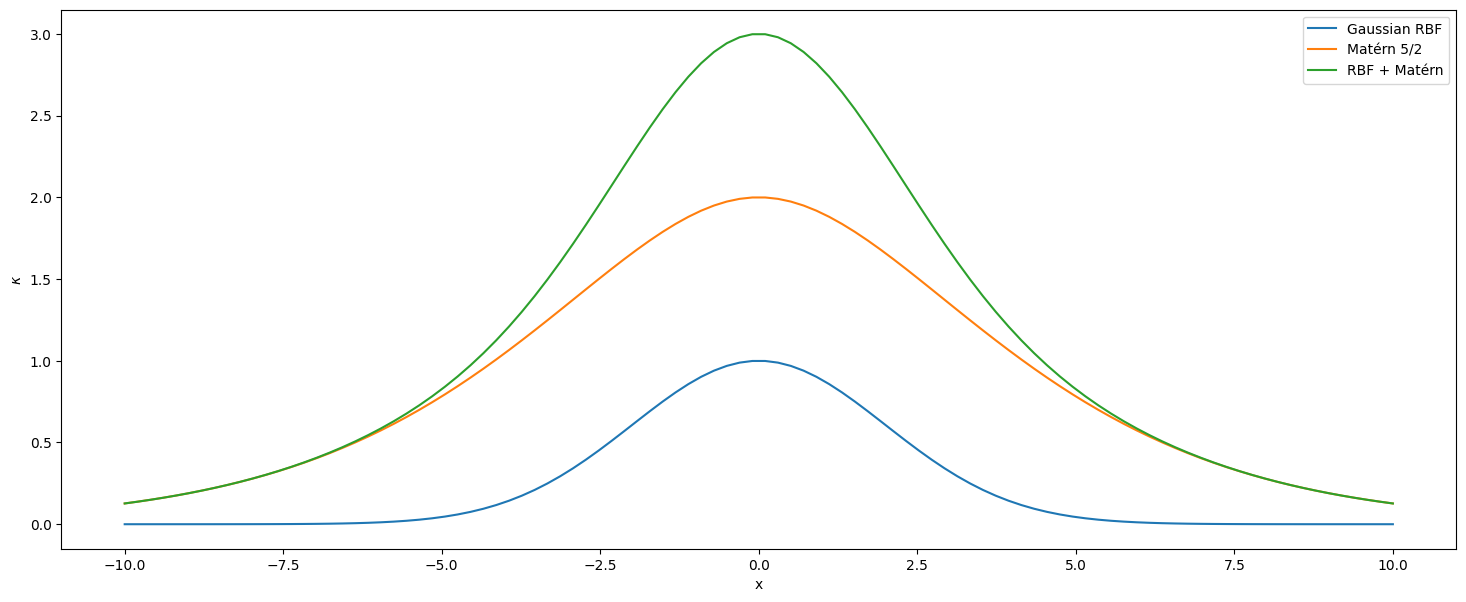

In [ ]:
# Our sample space : 100 samples in the interval [-10,10]
X = torch.linspace(-10., 10., 100)[:,None]

# Set up the plotting environment
plt.figure(figsize=(18,7))

# Here we sample from the consituent and composite kernels
with torch.no_grad():
  K_R   = k_R(X, torch.tensor([[0.]]))    # RBF
  K_M   = k_M(X, torch.tensor([[0.]]))    # Matern 5/2
  K_sum = k_sum(X, torch.tensor([[0.]]))  # RBF + Matern

# Plot each of our covariance vectors
plt.plot(X, K_R, X, K_M, X, K_sum)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Matérn 5/2", "RBF + Matérn"]);

#### Multiplying two kernels

We also demonstrate here the effect of multiplying two kernels. Here, we multiply an RBF and Periodic kernel, effectively encapsulating the periodicity into an RBF window:

In [ ]:
# Create the first kernel: a 1-D RBFKernel with lengthscale 5.0
k_R = RBFKernel(ard_num_dims=1)
k_R.initialize(**{'lengthscale': 5.0})

# Create the second kernel: a 1-D PeriodicKernel with lengthscale 1.0 and period 5.0
k_P = PeriodicKernel()
k_P.initialize(**{'lengthscale': 1.0, 'period_length': 5.0})

# Multiply the kernels together
k_mul = k_R * k_P

# Preview the properties of the composite kernel
show_params(k_mul)

Parameter name: kernels.0.raw_lengthscale,  raw_value = 4.99324,  constraint: Positive(), actual_value: 5.00000
Parameter name: kernels.1.raw_lengthscale,  raw_value = 0.54132,  constraint: Positive(), actual_value: 1.00000
Parameter name: kernels.1.raw_period_length,  raw_value = 4.99324,  constraint: Positive(), actual_value: 5.00000


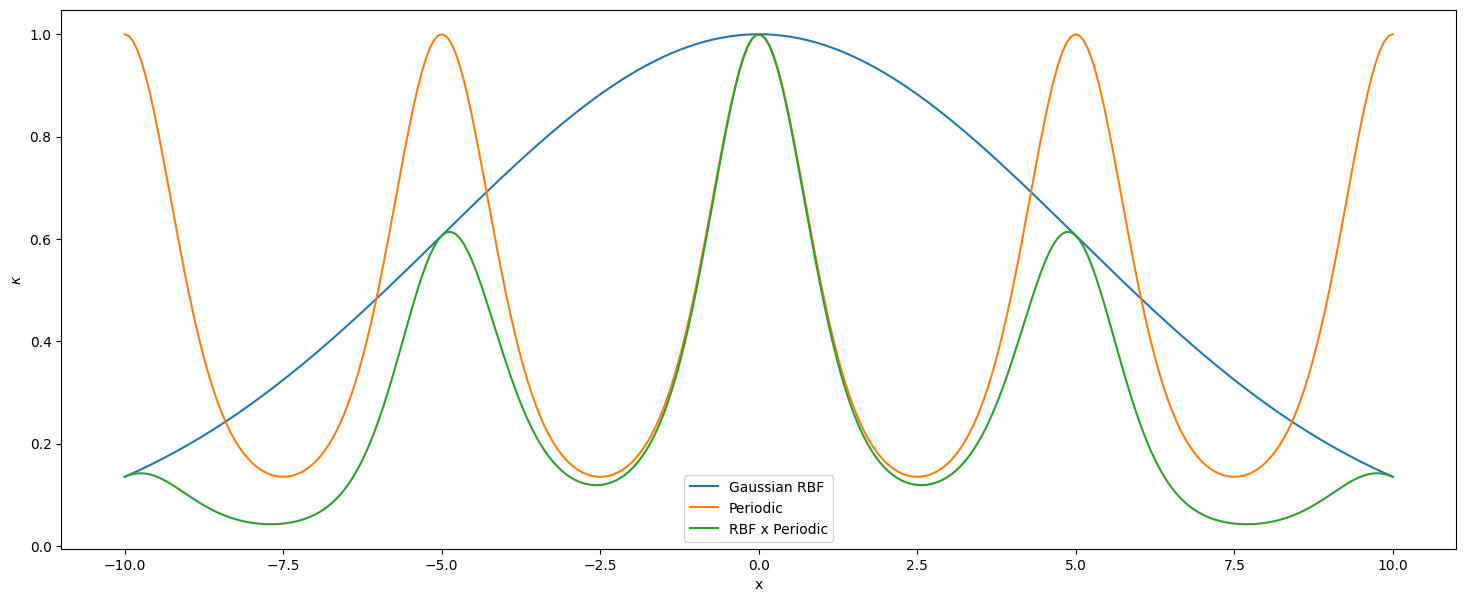

In [ ]:
# Our sample space : 300 samples in the interval [-10,10]
X = torch.linspace(-10., 10., 300)[:,None]

# Set up the plotting environment
plt.figure(figsize=(18,7))

# Here we sample from the consituent and composite kernels
with torch.no_grad():
  K_R   = k_R(X, torch.tensor([[0.]]))      # RBFKernel
  K_P   = k_P(X, torch.tensor([[0.]]))      # PeriodicKernel
  K_mul = k_mul(X, torch.tensor([[0.]]))    # RBF * PeriodicKernel

# Plot each of our covariance vectors
plt.plot(X, K_R, X, K_P, X, K_mul)

# Annotate plot
plt.xlabel("x"), plt.ylabel("$\kappa$")
plt.legend(labels=["Gaussian RBF", "Periodic", "RBF x Periodic"]);

## 4. Sampling from a Gaussian Process

A Gaussian process provides a prior over some infinite-dimensional function, defined by a mean function and covariance function

$$ f(x) \sim \mathcal{GP}(m(x), k(x,x')) $$


When we sample from the covariance function, $k$, to create a matrix over some sample space, we are creating a matrix of values that describe the covariance between sample points. Since it is not possible to sample every single point in an infinite dimensional function, we have to sample a finite subset of the input domain. Let $\mathbf{X}$ denote some sample inputs, and $\mathbf{K}$ the covariance matrix, with elements $K_{ij} = k(\mathbf{X}_i,\mathbf{X}_j)$, then we can describe the prior over $f(\mathbf{X})$ as a (finite-dimensional) normal distribution with covariance $\mathbf{K}$. As such, we can easily create samples of $f$ which, for a good choice of $\mathbf{X}$, are representative of the true function.

We can also sample from the kernel prior by creating a covariance matrix over a sample space and sampling from a zero-mean multivariate normal distribution with covariance $\mathbf{K}$. Below are examples of different kernels with different parameters, including composite kernels.

In [1]:
ks = [
  ScaleKernel(RBFKernel()),
  ScaleKernel(RBFKernel()),
  ScaleKernel(RBFKernel()),
  ScaleKernel(MaternKernel(nu=0.5)),
  ScaleKernel(MaternKernel(nu=1.5)),
  ScaleKernel(MaternKernel(nu=2.5)),
  ScaleKernel(PeriodicKernel()),
  ScaleKernel(CosineKernel()),
  ScaleKernel(BrownianKernel()),
  ScaleKernel(LinearKernel()),
  ConstantKernel(),
  PeriodicKernel() * RBFKernel(),
  LinearKernel() + MaternKernel(nu=0.5)
]  # List of example kernels

# set the parameters in some kernels
outputscales = [1., 1., 2.]
lengthscales = [1., 0.5, 0.25]
for i in range(3):
  ks[i].outputscale = outputscales[i]
  ks[i].base_kernel.lengthscale = lengthscales[i]

ks[6].base_kernel.period_length = 2.

# The name of our kernels (for the legend)
kernel_name = ["RBF ls=1", "RBF ls=0.5", "RBF ls=0.25, var=2", "Exponential", "Matern 3/2",
               "Matern 5/2", "Periodic", "Cosine", "Brownian", "Linear", "Bias", "Periodic x RBF", "Linear + Exponential"]

# Our sample space
X = torch.linspace(-5., 5., 250)[:, None]

print("The following plots demonstrate samples from a Gaussian process prior and the corresponding covariance matrix")

# Loop through our kernels
for i, k in enumerate(ks):
  # The mean function is set to 0
  mu = ZeroMean()(X)

  # Get the covariance matrix
  Cov = k(X)  # equivalent to k(X, X)

  # Build a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
  dist  = MultivariateNormal(mu, Cov)

  # Sample 5 times
  num_samples = 5
  Samples = dist.sample(sample_shape=torch.Size([num_samples]))

  with torch.no_grad():
    # Setup figure environment
    plt.figure(figsize=(18, 7))

    # Show samples on left hand side
    plt.subplot(121)
    for j in range(num_samples): # Loop through samples
      plt.plot(X[:, 0], Samples[j,:])
      plt.title(kernel_name[i])

    # Visualise covariance matrix on right hand side
    plt.subplot(122)
    plt.pcolor(Cov.numpy(), cmap='viridis')
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

NameError: name 'ScaleKernel' is not defined

These samples are from the Gaussian process prior made up of the covariance function and a zero mean. After GP regression, the fitted posterior can also be sampled in this manner, to get samples of the fitted function.

### Exercise 3

Can you identify the covariance function used to generate the following samples?

![exercise_3](https://github.com/gpschool/labs/raw/2019/.resources/lab1_kernel_samples_example.png)

Options: _Periodic * Matern 5/2; Matern 3/2 + Bias; Brownian * RBF; Linear * Cosine; RBF; Exponential_

(d) = exponential, (f) Matern + ?

Below is a utility function you may find helpful to plot kernel samples, e.g. `plot_K_samples(RBFKernel())`

In [ ]:
def plot_K_samples(kernel, num_samples=2):
  X = torch.linspace(0, 5., 250)[:, None]
  # Zero mean
  mu = ZeroMean()(X)
  # Get the covariance matrix
  Cov = kernel(X)

  # Sample from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
  Samples = MultivariateNormal(mu, Cov).sample(torch.Size([num_samples]))

  with torch.no_grad():
    for j in range(num_samples): # Loop through samples
      plt.plot(X[:],Samples[j,:])

(a)

(b)

(c)

(d)

(e)

(f)

## 5. Gaussian Process Regression

We will now use our Gaussian process prior with some observed data to form a GP regression model.

Suppose we have a data model for which we only have noisy observations, $y = f(x) + \epsilon$ at some small number of sample locations, $\mathbf{X}$. Here, we set up an example function

$$
    f(x) = -\cos(2\pi x) + \frac{1}{2}\sin(6\pi x)
$$
$$
    \mathbf{y} = f(\mathbf{X}) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.01)
$$

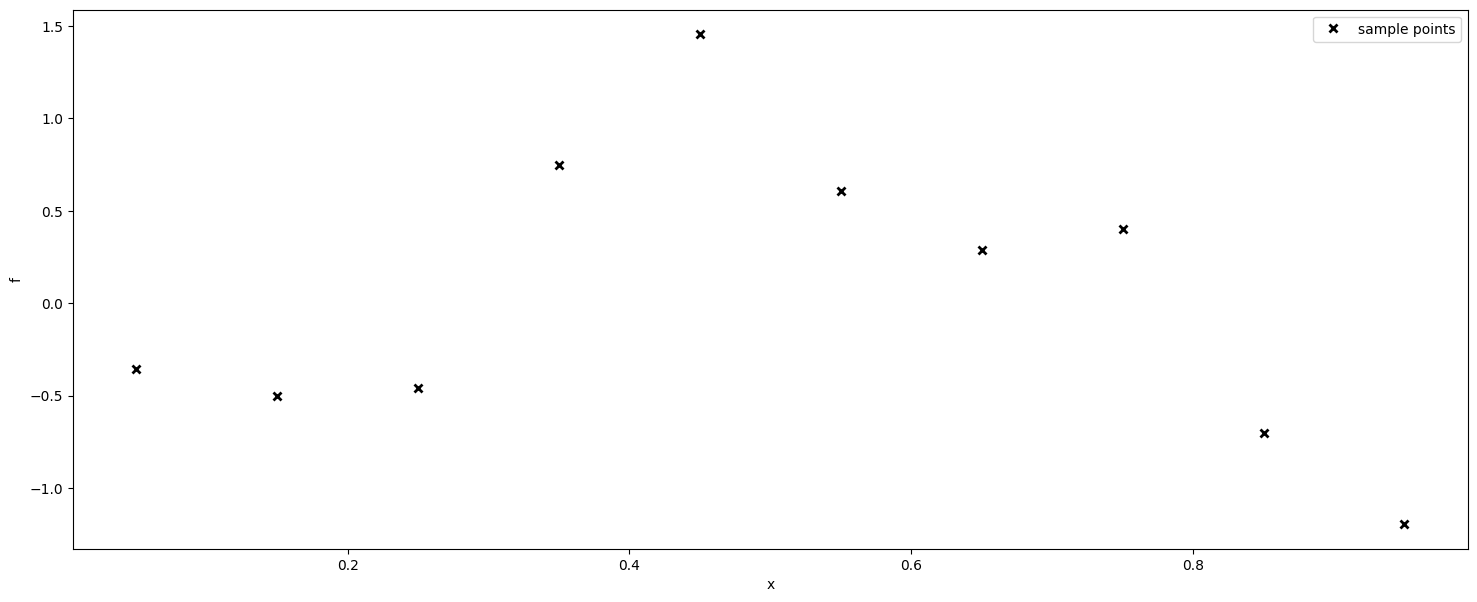

In [ ]:
# lambda function, call f(x) to generate data
f = lambda x: -torch.cos(2*torch.pi*x) + 0.5*torch.sin(6*torch.pi*x)

# 10 equally spaced sample locations
X = torch.linspace(0.05, 0.95, 10)[:,None]

# y = f(X) + epsilon
Y = f(X) + torch.normal(mean=0.0, std=0.1, size=(10, 1))

# Setup our figure environment
plt.figure(figsize=(18, 7))

# Plot observations
plt.plot(X, Y, "kx", mew=2)

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

We will first fit a Gaussian process using the exact equations.

A Gaussian process regression model using a Gaussian RBF covariance function can be defined first by setting up the kernel:

In [ ]:
k = ScaleKernel(RBFKernel(ard_num_dims=1))

k.initialize(**{'outputscale': 1.0, 'base_kernel.lengthscale': 0.1})

ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

And then combining it with the data to form a Gaussian process regression model, with $\mathbf{X}^*$ representing _any_ new inputs (imagine $\mathbf{f}^*$ approximates $f(\mathbf{X}^*)$):

$$
\left.\mathbf{f}^*\,\right|\,\mathbf{X}^*,\mathbf{X},\mathbf{y} \sim \mathcal{N}\left(\mathbf{m}, \mathbf{C}\right),
$$

where $
\mathbf{m} = \mathbf{K}_{*x}(\mathbf{K}_{xx} + \sigma^2\mathbf{I})^{-1}\mathbf{y}$ and $\mathbf{C} = \mathbf{K}_{**} -  \mathbf{K}_{*x}(\mathbf{K}_{xx} + \sigma^2\mathbf{I})^{-1}\mathbf{K}_{*x}^\text{T}
$ and covariance matrices are defined by evaluations of the kernel functions: $\mathbf{K}_{xx} = k(\mathbf{X}, \mathbf{X})$; $\mathbf{K}_{*x} = k(\mathbf{X}^*, \mathbf{X})$; and $\mathbf{K}_{**} = k(\mathbf{X}^*,\mathbf{X}^*)$.

In [ ]:
# New test points to sample function from
Xnew = torch.linspace(-0.05, 1.05, 100)[:, None]

with torch.no_grad():
  # Covariance between training sample points (+ Gaussian noise)
  Kxx = k(X,X) + 1 * torch.eye(10)
  Kxx = Kxx.to_dense()

  # Covariance between training and test points
  Ksx = k(Xnew,X)

  # Covariance between test points
  Kss = k(Xnew,Xnew)

  # The mean of the GP fit (note that @ is matrix multiplcation: A @ B is equivalent to torch.matmul(A,B))
  mean = Ksx @ torch.linalg.inv(Kxx) @ Y
  # The covariance matrix of the GP fit
  Cov = Kss - Ksx @ torch.linalg.inv(Kxx) @ Ksx.mT

Here we define a quick plotting utility function for our GP fits. We will use the method below, which plots the mean and 95% confidence fit of a GP for a given input $\mathbf{X}^*$. Optionally, we will allow it to plot the initial training points.

In [ ]:
@torch.no_grad()
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    X,m,C = X.numpy(), m.numpy(), C.numpy()
    # Plot 95% confidence interval
    plt.fill_between(X[:,0],
                     m - 1.96*np.sqrt(np.diag(C)),
                     m + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-", label="GP fit")

    plt.xlabel("x"), plt.ylabel("f")

    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_.numpy(), Y_.numpy(), "kx", mew=2, label="sample points")
    plt.legend()

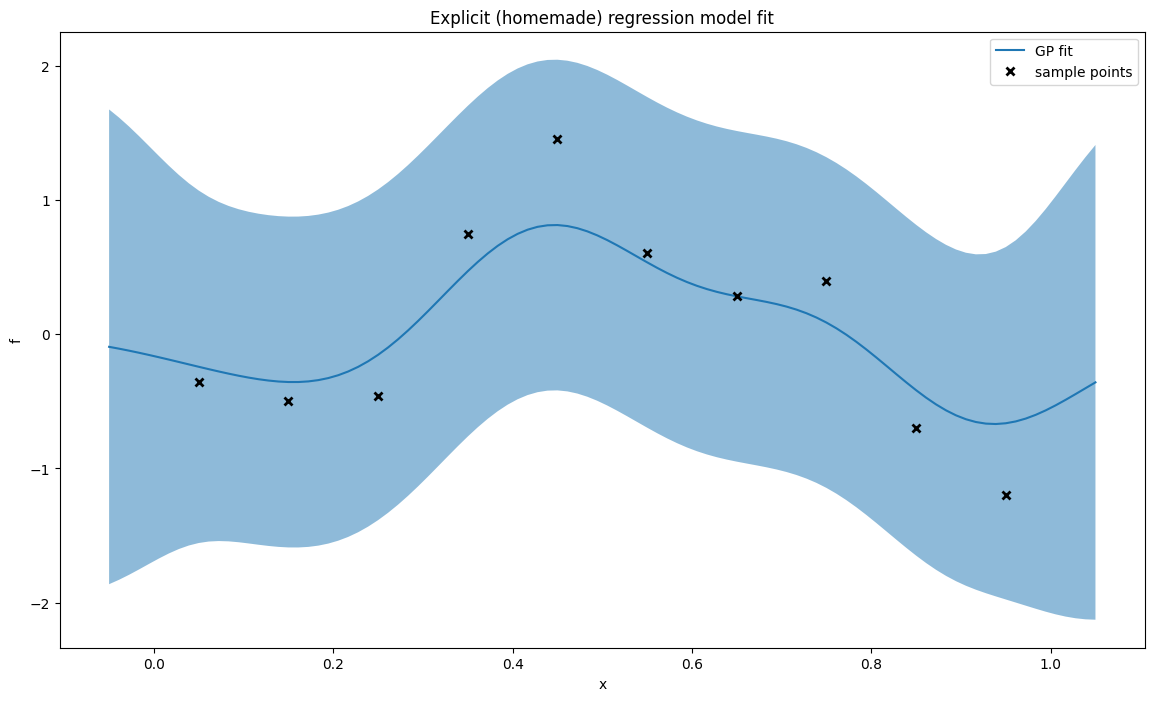

In [ ]:
plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean[:,0], Cov, training_points=(X,Y))
plt.title("Explicit (homemade) regression model fit");

We can also do Gaussian process regression using `gpytorch` by creating a GP regression model with the following objects:

1. A GP model (`gpytorch.models.ExactGP`) - This handles most of the inference.
2. A Likelihood (`gpytorch.likelihoods.GaussianLikelihood`) - This is the most common likelihood used for GP regression.
3. A Mean - This defines the prior mean of the GP (by default we use `ZeroMean()`).
4. A Kernel - This defines the prior covariance of the GP (by default we use `ScaleKernel(RBFKernel())`).
5. A MultivariateNormal Distribution (`gpytorch.distributions.MultivariateNormal`) - This is the object used to represent multivariate normal distributions.

In [ ]:
class ExactGPModel(ExactGP):
    def __init__(self, X, Y, mean_module, covar_module, likelihood):
        super(ExactGPModel, self).__init__(X, Y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Specify likelihood
likelihood = GaussianLikelihood()

mean_module = ZeroMean()
covar_module = ScaleKernel(RBFKernel(ard_num_dims=1)) # inputs are 1-D

# Specify model
model = ExactGPModel(X.squeeze(1), Y.squeeze(1), mean_module, covar_module, likelihood)

# Initialize the model
model.initialize(**{'likelihood.noise': 1.0, 'covar_module.outputscale': 1.0, 'covar_module.base_kernel.lengthscale': 0.1})

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

We make predictions by calling the model, which _should_ give the same result as our basic implementation:

In [ ]:
# Use gpytorch model to calculate the mean and covariance of the fit at Xnew
def prediction(model, X_, noisy=False, dist=False):
  """Utility function for making predictions"""
  model.eval()
  with torch.no_grad():
    if noisy == False:
        pred = model(X_)
        if dist:
          return pred
        mean, Cov = pred.mean, pred.covariance_matrix
    elif noisy:
        pred = model.likelihood(model(X_))
        if dist:
          return pred
        mean, Cov = pred.mean, pred.covariance_matrix
  return mean, Cov

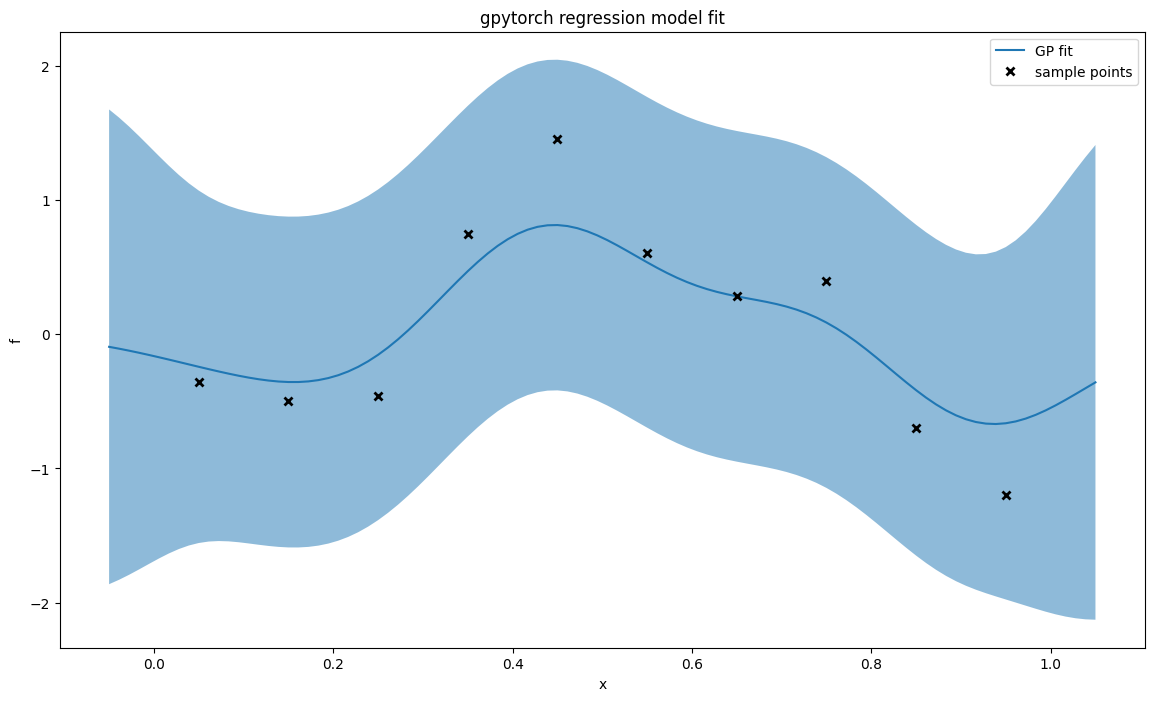

In [ ]:
mean, Cov = prediction(model, Xnew)  # noiseless prediction
plt.figure(figsize=(14, 8))
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("gpytorch regression model fit");

It can be clearly seen that this *is* the same fit as our model above. However, using gpytorch gives flexibility and ease of use for extending the capabilities of the fitting, including use of different kernels, optimising parameters and solving more complicated problems, including classification. We also don't need to write explicit equations and manually create covariances matrices.

### Exercise 4

(a) What do you think of this initial fit? Does the prior given by the GP seem to be adapted?

(b) The parameters of the model can be editted much like those of the kernel. For example,
```
likelihood.noise_covar.noise = 0.1
```
or
```
model.covar_module.outputscale = 2.0
```
Change the values of the parameters to try and obtain a better fit of the GP. You can recalculate the updated mean and covariance after changing the values by calling `model(Xnew)` as above.

(c) Given that we can obtain the mean and covariance of the GP fit, we can also sample the GP posterior as a multivariate Gaussian process. This can be done as in Section 4, where we sampled the priors as defined by the kernels. Obtain 10 samples from the GP posterior and plot them alongside the data. Try to simulate noisy measurements calling `likelihood(model())` (rather than `model()`).

## 6. Covariance Function Parameter Estimation

As discussed in the lectures, the values of kernel parameters can be estimated by maximising the likelihood of the observations. This is useful to optimise our estimate of the underlying function, without eye-balling parameters to get a good fit.

In `GPyTorch`, we need to write the training loop, using an optimizer to update the parameters of the model.

<u>Two version: using LBFGS or Adam</u>

In [ ]:
def train_GP_LBFGS(model, num_training_iterations=200, lr=0.1, max_iter=20, print_iter=50):
  X = model.train_inputs[0]
  Y = model.train_targets

  # Set the model to training mode
  model.train()

  # Set the LBFGS optimizer in PyTorch
  optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=max_iter)  # load model's parameters

  # Marginal log likelihood for GP
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

  for i in range(num_training_iterations):
    def closure():
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(X)
      # Calculate loss and backprop gradients
      loss = - mll(output, Y)
      loss.backward()
      return loss

    # update
    optimizer.step(closure)

    # print the training process
    if (i + 1) % print_iter == 0:
      with torch.no_grad():
        loss = - mll(model(model.train_inputs[0]), model.train_targets).item()
        noise = model.likelihood.noise.item()
        print(
          f'Iteration {i + 1}/{num_training_iterations} - Loss: {loss:.3f}  noise: {noise:.3e}'
        )

  # Evaluate final loss
  with torch.no_grad():
      final_loss = - mll(model(model.train_inputs[0]), model.train_targets).item()
      print(f'Final Loss: {final_loss:.3f}')

  return model, final_loss


In [ ]:
_, _ = train_GP_LBFGS(model, num_training_iterations=100, lr=0.1)

Iteration 50/100 - Loss: 0.735  noise: 1.000e-04
Iteration 100/100 - Loss: 0.735  noise: 1.000e-04
Final Loss: 0.735


In [ ]:
def train_GP_Adam(model, num_training_iterations=200, lr=0.1, print_iter=50):
  X = model.train_inputs[0]
  Y = model.train_targets

  model.train()

  # Set the Adam optimizer in PyTorch
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

  for i in range(num_training_iterations):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, Y)
    loss.backward()
    optimizer.step()

    if (i + 1) % print_iter == 0:
      noise = model.likelihood.noise.item()
      print(
        f'Iteration {i + 1}/{num_training_iterations} - Loss: {loss:.3f}  noise: {noise:.3e}'
      )

  # Evaluate final loss
  with torch.no_grad():
      final_loss = - mll(model(model.train_inputs[0]), model.train_targets).item()
      print(f'Final Loss: {final_loss:.3f}')

  return model, final_loss

# train_GP_Adam(model, num_training_iterations=100, lr=0.1)

<u>We can print all the raw parameters in GPR:</u>

In [ ]:
show_params(model)

Parameter name: likelihood.noise_covar.raw_noise,  raw_value = -20.52196,  constraint: GreaterThan(1.000E-04), actual_value: 0.00010
Parameter name: covar_module.raw_outputscale,  raw_value = -0.02421,  constraint: Positive(), actual_value: 0.68112
Parameter name: covar_module.base_kernel.raw_lengthscale,  raw_value = -2.06901,  constraint: Positive(), actual_value: 0.11895


The regression fit with the optimised parameters can be plotted:

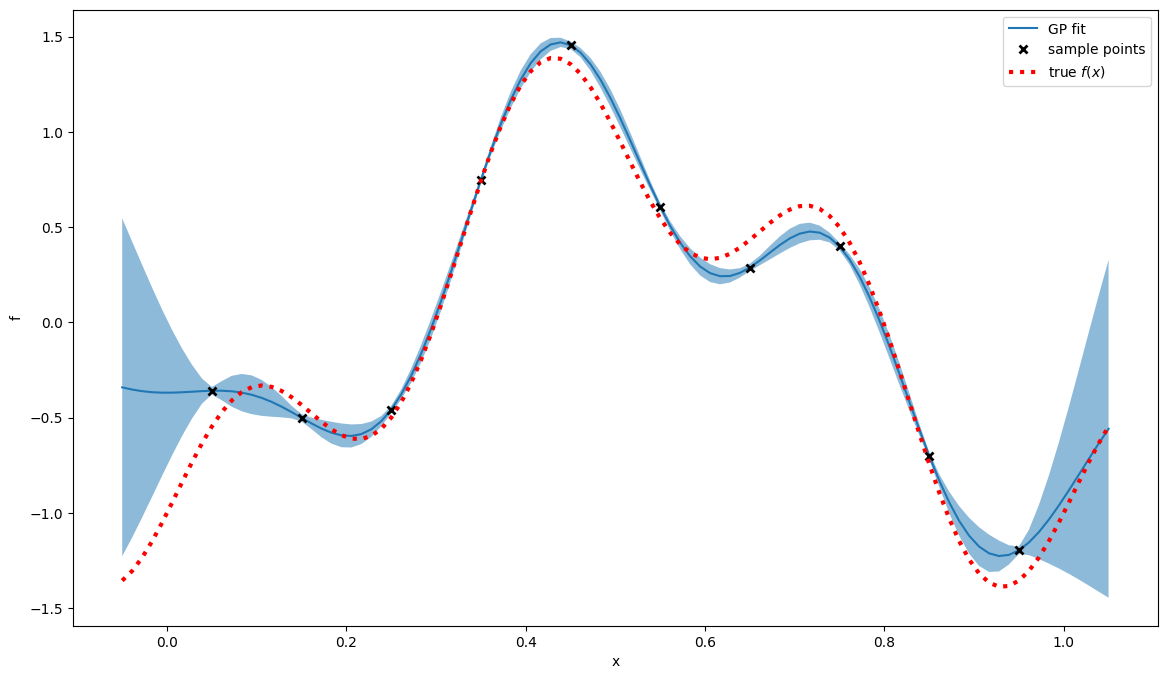

In [ ]:
mean, Cov = prediction(model, Xnew)

# Setup the figure environment
plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X, Y))
plt.plot(Xnew, f(Xnew), "r:", lw=3, label="true $f(x)$")
plt.legend()

### Parameter constraints

We can see in the above model that the regression model is fit to the data, as the optimiser has minimised the noise effect in the model, `Gaussian_noise.variance`. If we *know*, or can reasonably approximate, the variance of the observation noise $\epsilon$, we can fix this parameter for the optimiser, using `fix`, which in the case of the above is $0.01$. We can also limit the values that the parameters take by adding constraints. For example, the variance and lengthscale can only be positive, so calling `constrain_positive`, we can enforce this (note that this is the default constraint for GP regression anyway).

In fact, the default constraint of the noise in GPyTorch `GaussianLikelihood` is `GreaterThan`. In other words, the noise variance can not be less than $10^{-4}$. We may change this constraint to ohter types, e.g., `Positive` to get a similar noise value.

In [ ]:
# Constrain the regression parameters to be positive only
# change the constraints from `GreaterThan` to `Positive()`
model.likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.Positive())

# Fix the Gaussian noise variance at 0.01
model.likelihood.noise = 0.01 # (Reset the parameter first)
model.likelihood.raw_noise.requires_grad = False

# Reoptimise
_, _ = train_GP_LBFGS(model, num_training_iterations=100)

# print parameters
print(" ")
show_params(model)

Iteration 50/100 - Loss: 0.771  noise: 1.000e-02
Iteration 100/100 - Loss: 0.771  noise: 1.000e-02
Final Loss: 0.771
 
Parameter name: likelihood.noise_covar.raw_noise,  raw_value = -4.60017,  constraint: Positive(), actual_value: 0.01000
Parameter name: covar_module.raw_outputscale,  raw_value = -0.11494,  constraint: Positive(), actual_value: 0.63733
Parameter name: covar_module.base_kernel.raw_lengthscale,  raw_value = -2.09389,  constraint: Positive(), actual_value: 0.11619


We can see our constraints in the corresponding column in the above table, where "`+ve`" means we are constrained to positive values, and `fixed` means the optimiser will not try and optimise this parameter. We can see here that the variance of the noise in the model is unchanged by the optimiser. Looking at the resulting plot, we can see that we have a much more reasonable confidence in our estimate, and that the true function is hard to distinguish from samples drawn from our fit, indicating that we have reasonable approximation of the true function given noisy observations.

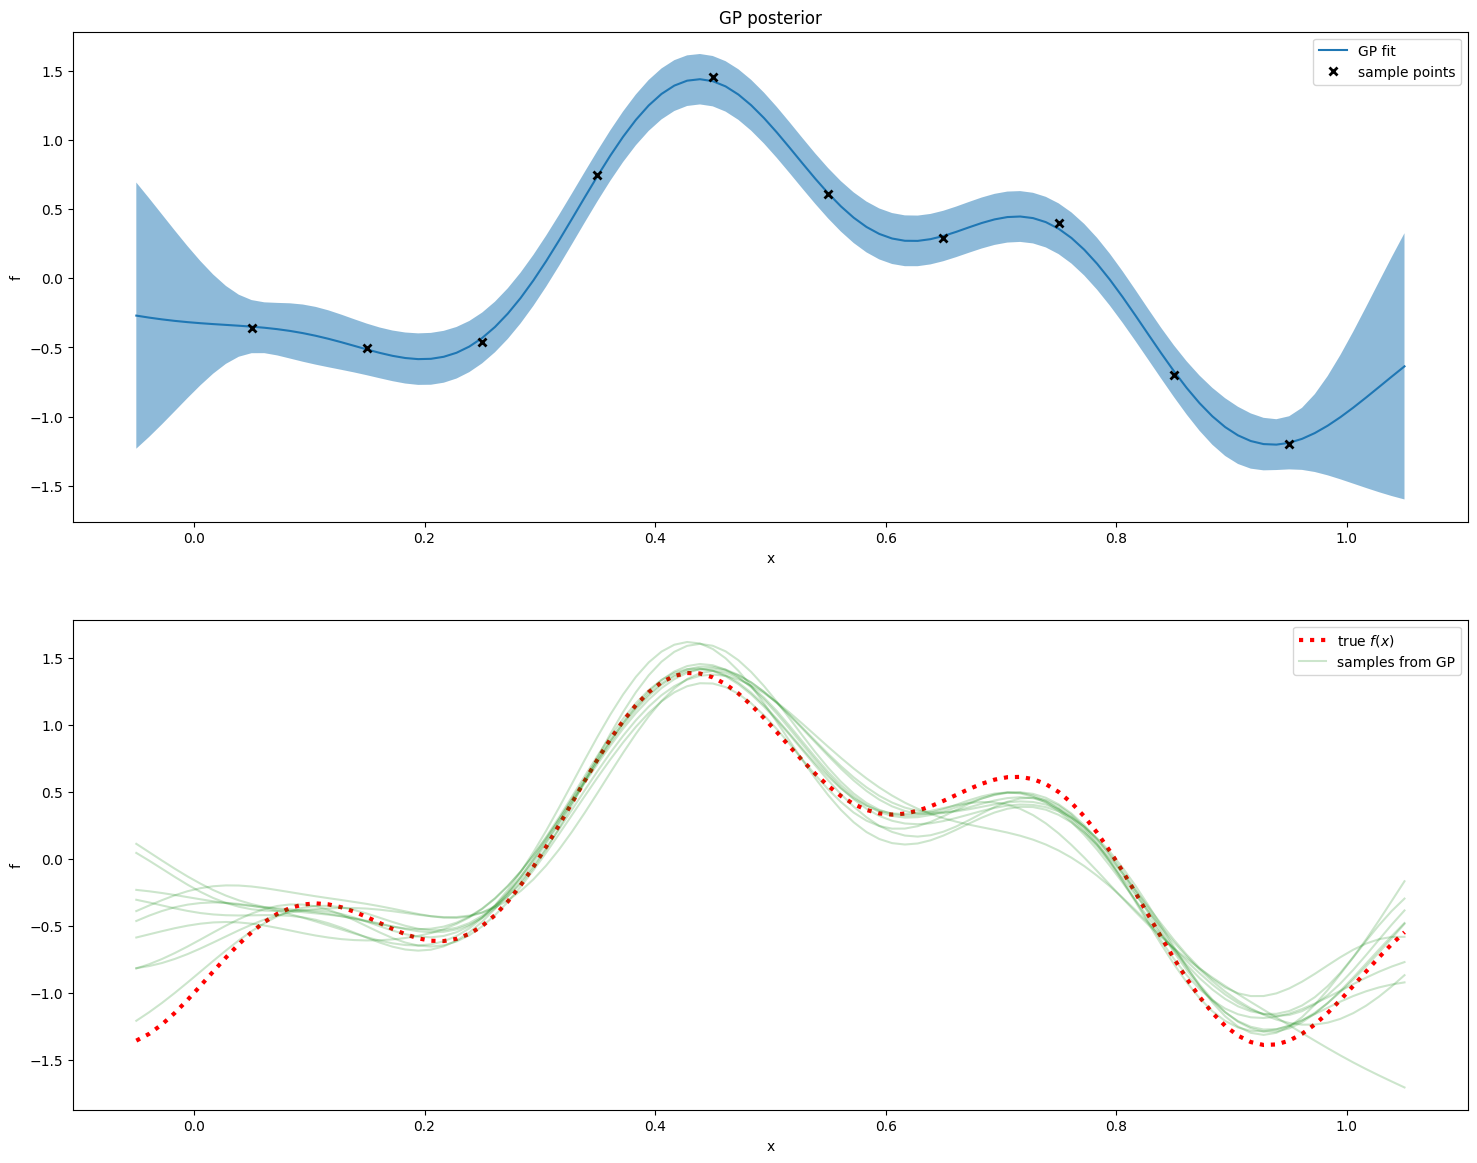

In [ ]:
# Setup our figure environment
plt.figure(figsize=(18, 14))

model.eval()
with torch.no_grad():
  # Get mean and covariance of optimised GP
  pred = model(Xnew) # noiseless prediction
  mean, Cov = pred.mean, pred.covariance_matrix

  Z = pred.sample(sample_shape=torch.Size([10]))

# The top plot shows our mean regression fit and 95% confidence intervals
plt.subplot(211)
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GP posterior")
plt.subplot(212)

plt.plot(Xnew, f(Xnew),"r:", lw=3)

for z in Z:
    plt.plot(Xnew,z, "g-", alpha=0.2)

plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["true $f(x)$", "samples from GP"]);

Using the prior knowledge of the noise in the data has given us a reasonably good approximation of the true function. The samples from the GP demonstrate fits to the observed data and roughly follow the shape of the true function $f$, particularly in the range for which we have samples.

### Exercise 5

The function we used is a sum of sinusoids, and therefore has inherent periodicity. However, we only have samples for a single period, so this is not directly seen in the domain of $[0, 1]$.

(a) Try predicting the function on the range of $[0, 2]$ instead (`Xnew = torch.linspace(0., 2., 250)[:,None]`), and compare the fitted GP posterior with the true function $f$.

*Note, you shouldn't need to retrain the model or adjust the hyperparameters.*

(b) Comment on the fit of the GP, and the uncertainty in regions where we have no observations. Is the GP still a good fit? How might we produce a better fit, for example, if we knew $f(x)$ had a periodic nature?

## 7. Real World Example

We'll consider now a classic real world example using atmospheric $\mathrm{CO}_{2}$ observations from the Mauna Loa Observatory, Hawaii. The dataset is a good demonstration of the predictive power of Gaussian processes, and we will use it to show how we can encode our prior beliefs to combine kernels.

First, we need to download the dataset.

In [ ]:
import pickle
import requests

# Load in the data
req = requests.get('https://github.com/gpschool/labs/raw/2023/.resources/mauna_loa')
data = pickle.loads(req.content)

print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['info'])


Data keys:
dict_keys(['X', 'Y', 'Xtest', 'Ytest', 'info', 'citation', 'details', 'files', 'license', 'size', 'urls'])

Citation:
Mauna Loa Data. Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

Info:
Mauna Loa data with 545 values used as training points.


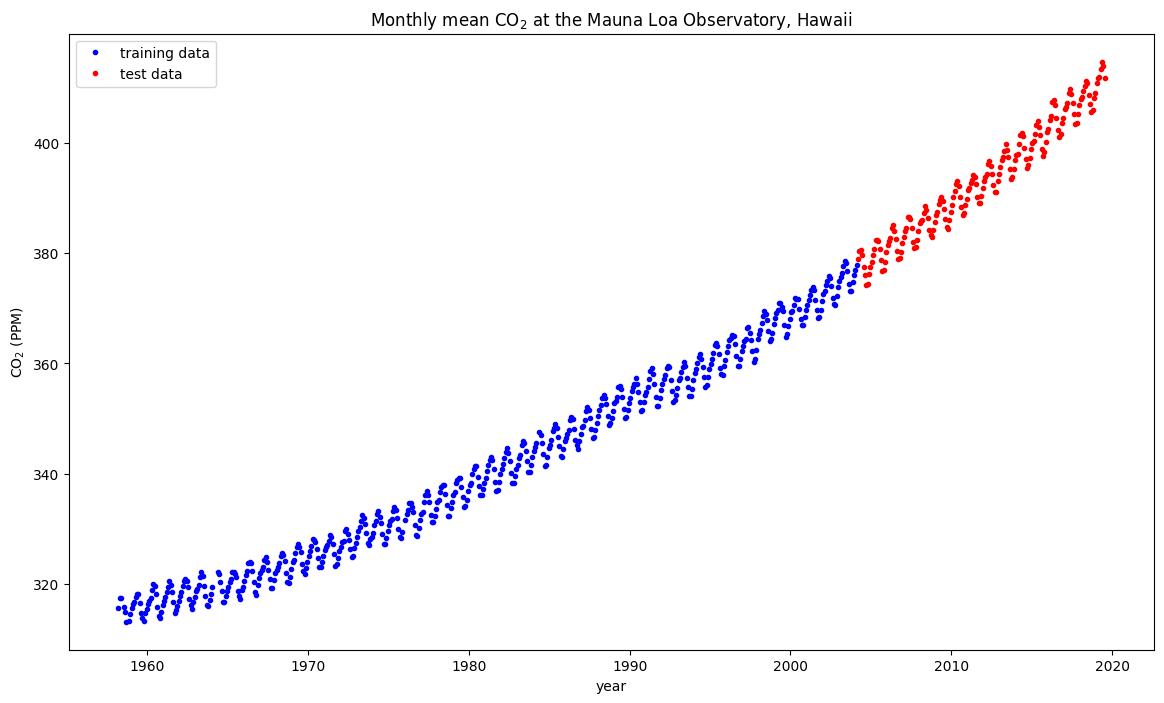

In [ ]:
# Training data (X = input, Y = observation)
X, Y = torch.tensor(data['X']), torch.tensor(data['Y'])

# Test data (Xtest = input, Ytest = observations)
Xtest, Ytest = torch.tensor(data['Xtest']), torch.tensor(data['Ytest'])

# Set up our plotting environment
plt.figure(figsize=(14, 8))

# Plot the training data in blue and the test data in red
plt.plot(X, Y, "b.", Xtest, Ytest, "r.")

# Annotate plot
plt.legend(labels=["training data", "test data"])
plt.xlabel("year"), plt.ylabel("CO$_2$ (PPM)"), plt.title("Monthly mean CO$_2$ at the Mauna Loa Observatory, Hawaii");

**You may want to subsample the data to save time during the labs**

Run the following to reduce the datasize by only using every other training point:

In [ ]:
X = X[::2, :]
Y = Y[::2, :]

### Naive GP regression

First, we will try to fit a basic RBF to our data, as we have used in previous examples

In [ ]:
# define likelihood and model
likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
likelihood.noise = 1.0

mean_module = ZeroMean()
covar_module = ScaleKernel(RBFKernel())

covar_module.outputscale = 1.0
covar_module.base_kernel.lengthscale = 1.0

model = ExactGPModel(X.squeeze(1), Y.squeeze(1), mean_module, covar_module, likelihood)

# training
# _, _ = train_GP_Adam(model, num_training_iterations=500, lr=0.01, print_iter=50)
_, _ = train_GP_LBFGS(model, num_training_iterations=200, lr=0.01, print_iter=50)
show_params(model)

Iteration 50/200 - Loss: 8.955  noise: 9.201e+00
Iteration 100/200 - Loss: 2.279  noise: 4.603e+00
Iteration 150/200 - Loss: 2.245  noise: 4.578e+00
Iteration 200/200 - Loss: 2.245  noise: 4.578e+00
Final Loss: 2.245
Parameter name: likelihood.noise_covar.raw_noise,  raw_value = 4.56785,  constraint: Positive(), actual_value: 4.57818
Parameter name: covar_module.raw_outputscale,  raw_value = 119176.29268,  constraint: Positive(), actual_value: 119176.29268
Parameter name: covar_module.base_kernel.raw_lengthscale,  raw_value = 101.20877,  constraint: Positive(), actual_value: 101.20877


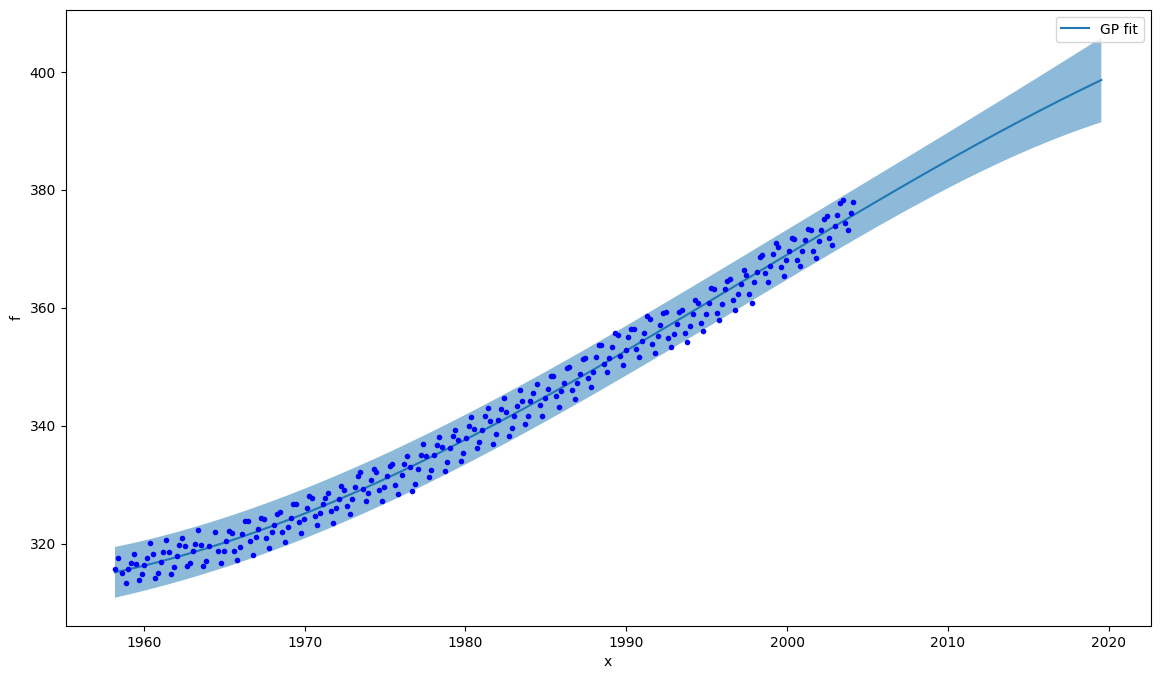

In [ ]:
Xnew = torch.cat((X, Xtest), dim=0)

mean, Cov = prediction(model, Xnew, noisy=True)

# Setup the figure environment
plt.figure(figsize=(14, 8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");

It is possible to make the model fit the data near perfectly by minimising the variance of the Gaussian noise in the likelihood and fixing the kernel variance.

In [ ]:
# Effectively remove noise parameter (needs to be >0, so select value that is very low)

model.likelihood.noise = 0.00001 # (Reset the parameter first)
model.likelihood.raw_noise.requires_grad = False

# We will fix the variance as well, so that only the lengthscale is optimised
model.covar_module.outputscale = 10.
model.covar_module.raw_outputscale.requires_grad = False

# This should minimize the lengthscale to fit closely to the training points
# _, _ = train_GP_Adam(model, num_training_iterations=500, lr=0.01, print_iter=50)
_, _ = train_GP_LBFGS(model, num_training_iterations=200, lr=0.01, print_iter=50)
show_params(model)

Iteration 50/200 - Loss: 5853.380  noise: 1.000e-05
Iteration 100/200 - Loss: 5853.380  noise: 1.000e-05
Iteration 150/200 - Loss: 5853.380  noise: 1.000e-05
Iteration 200/200 - Loss: 5853.380  noise: 1.000e-05
Final Loss: 5853.380
Parameter name: likelihood.noise_covar.raw_noise,  raw_value = -11.51292,  constraint: Positive(), actual_value: 0.00001
Parameter name: covar_module.raw_outputscale,  raw_value = 9.99995,  constraint: Positive(), actual_value: 10.00000
Parameter name: covar_module.base_kernel.raw_lengthscale,  raw_value = -4.58503,  constraint: Positive(), actual_value: 0.01015


**But** this has no predictive power, and we have really just overfitted to the training data

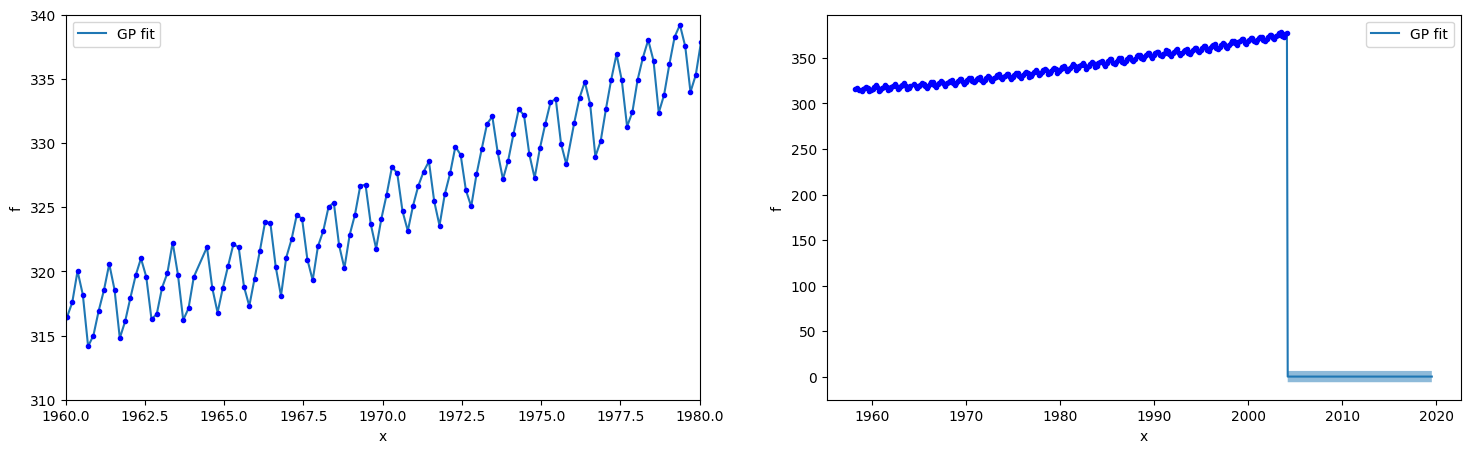

In [ ]:
mean, Cov = prediction(model, Xnew, noisy=True)

plt.figure(figsize=(18, 5))

# The left plot shows the GP fit to a subsample of our training set
plt.subplot(121)
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");
plt.gca().set_xlim([1960,1980]), plt.gca().set_ylim([310, 340])

# The right plot shows that the GP has no predictive power and reverts to 0
plt.subplot(122)
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");

### GP Regression with combined covariance functions

Taking a look at the training data, we can see a number of features that occur in the data. There is a clear periodic trend that is yearly, and an approximately linear trend. We can use this prior information in our choice of kernel to give some meaning to the GP fit.

First, we will look at the linear trend. It should be obvious that the overall trend (ignoring the periodicity) can be described approximately by $f(x) \approx a + bx$. To embed this as a covariance function, we can use the  `Linear` covariance function, which adds a linear trend to the covariance.

### Exercise 6

(a) Create a `Linear` kernel with reasonable estimates of the parameters that represent the trend?

(b) How might we encode this trend in the mean estimate of the GP ?

(c) Create a GP regression model using the kernels to fit the data. Comment on good is the fit and the predictive power of the model?

### Periodicity

There is a seasonal trend over the year, and that a simple linear fit cannot capture this information. However, we can add this using our choice of kernel by adding a `PeriodicKernel` kernel to our regression model. It's evident to the data that the period is yearly, so a period of $\omega=1$ is a sensible choice for our initial parameter:

In [ ]:
# define likelihood and model
likelihood = GaussianLikelihood()
likelihood.noise = 1.0

mean_module = ZeroMean()

covar_module = ConstantKernel() + LinearKernel() + ScaleKernel(PeriodicKernel())
# Set parameters in kernel
covar_module.kernels[0].constant = torch.tensor(10000.)
covar_module.kernels[1].variance = 1.
covar_module.kernels[2].outputscale = 1.
covar_module.kernels[2].base_kernel.period_length = 1.
covar_module.kernels[2].base_kernel.lengthscale = 4.

model = ExactGPModel(X.squeeze(1), Y.squeeze(1), mean_module, covar_module, likelihood)

# training parameters to fit closely to the training points
# _, _ = train_GP_Adam(model, num_training_iterations=500, lr=0.01, max_iter=1000, print_iter=50)
_, _ = train_GP_LBFGS(model, num_training_iterations=200, lr=0.01, max_iter=1000, print_iter=50)

Iteration 50/200 - Loss: 2.224  noise: 4.280e+00
Iteration 100/200 - Loss: 2.224  noise: 4.280e+00
Iteration 150/200 - Loss: 2.224  noise: 4.280e+00
Iteration 200/200 - Loss: 2.224  noise: 4.280e+00
Final Loss: 2.224


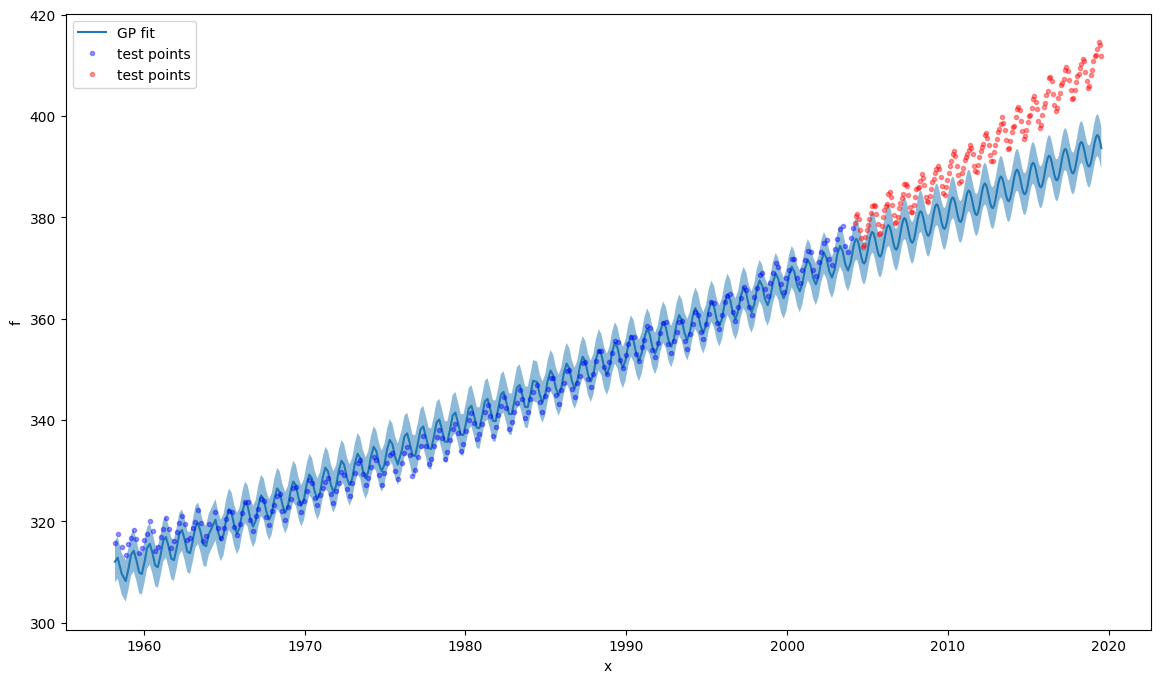

In [ ]:
mean, Cov = prediction(model, Xnew, noisy=True)

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4, label="test points");
plt.legend()

In [ ]:
show_params(model)

Parameter name: likelihood.noise_covar.raw_noise,  raw_value = 4.26639,  constraint: GreaterThan(1.000E-04), actual_value: 4.28042
Parameter name: covar_module.kernels.0.raw_constant,  raw_value = 66570.13881,  constraint: Positive(), actual_value: 66570.13881
Parameter name: covar_module.kernels.1.raw_variance,  raw_value = 110.42085,  constraint: Positive(), actual_value: 110.42085
Parameter name: covar_module.kernels.2.raw_outputscale,  raw_value = 2739408.71146,  constraint: Positive(), actual_value: 2739408.71146
Parameter name: covar_module.kernels.2.base_kernel.raw_lengthscale,  raw_value = 495537.11917,  constraint: Positive(), actual_value: 495537.11917
Parameter name: covar_module.kernels.2.base_kernel.raw_period_length,  raw_value = 0.54025,  constraint: Positive(), actual_value: 0.99932


The `RBF` kernel describes a smoother (Gaussian) decay, which may be a better model for changes in the periodic signal.

In [ ]:
# define likelihood and model
likelihood = GaussianLikelihood()
likelihood.noise = 1.0

mean_module = ZeroMean()

covar_module = ScaleKernel(MaternKernel(nu=0.5)) + ConstantKernel() + LinearKernel() + ScaleKernel(PeriodicKernel()) * ScaleKernel(RBFKernel()) # + WhiteNoiseKernel(noise_variance=1e-4) # adding Jitter for numerical stability
# Set parameters in kernel
covar_module.kernels[0].outputscale = 1.
covar_module.kernels[0].base_kernel.lengthscale = 1.
covar_module.kernels[1].constant = torch.tensor(10000.)
covar_module.kernels[2].variance = 1.
covar_module.kernels[3].kernels[0].outputscale = 1.
covar_module.kernels[3].kernels[0].base_kernel.period_length = 1.
covar_module.kernels[3].kernels[0].base_kernel.lengthscale = 4.
covar_module.kernels[3].kernels[1].outputscale = 1.
covar_module.kernels[3].kernels[1].base_kernel.lengthscale = 1.

model = ExactGPModel(X.squeeze(1), Y.squeeze(1), mean_module, covar_module, likelihood)

# training parameters to fit closely to the training points
# _, _ = train_GP_Adam(model, num_training_iterations=500, lr=0.01, max_iter=50, print_iter=50)
_, _ = train_GP_LBFGS(model, num_training_iterations=200, lr=0.01, max_iter=50, print_iter=50)

Iteration 50/200 - Loss: 0.507  noise: 3.912e-02
Iteration 100/200 - Loss: 0.504  noise: 3.719e-02
Iteration 150/200 - Loss: 0.504  noise: 3.719e-02
Iteration 200/200 - Loss: 0.504  noise: 3.719e-02
Final Loss: 0.504


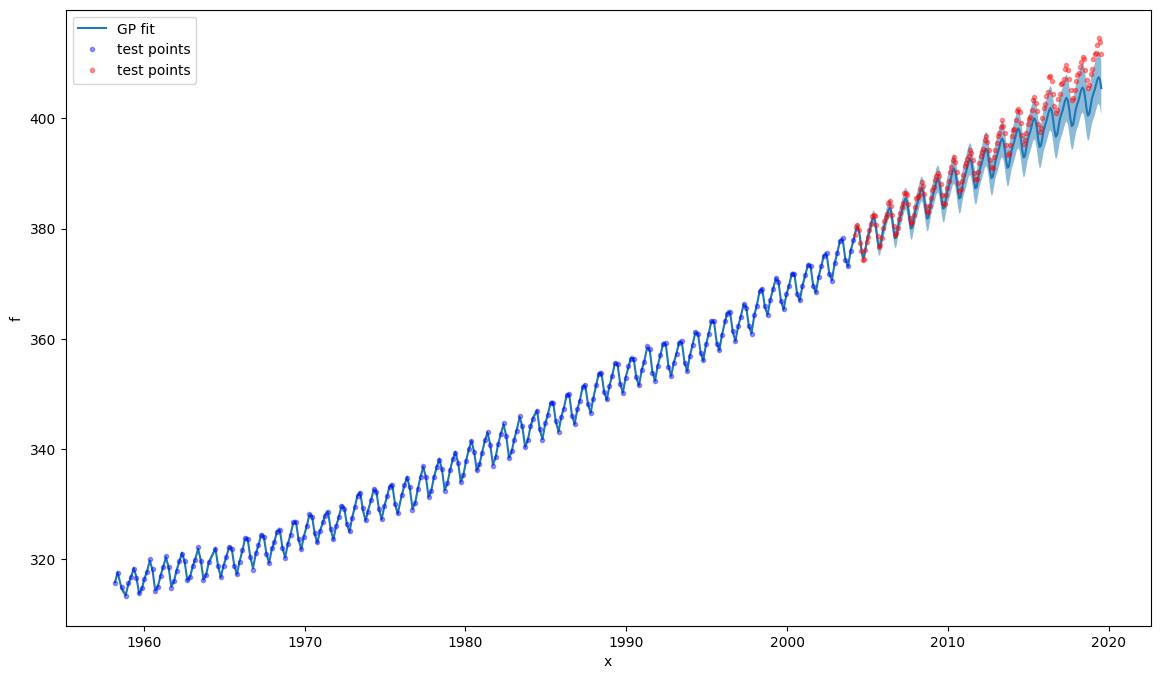

In [ ]:
mean, Cov = prediction(model, Xnew, noisy=True) # noisy prediction

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4, label="test points");
plt.legend()

We can see that with even with our initial (mostly default) parameter choices, the GP fit to the training data is representative of the trends we are observing. However, the prediction of the test data is relatively poor (though we still have an upward trend). The obvious step now is to optimise our kernel parameters.

Optimisation of the GP in itself is imperfect, often because the likelihood we are maximising can be multimodal, or flat, and so it can get stuck in local-maxima. It is always important to sanity-check the GP fit when optimising the parameters, to mitigate problems that could occur as a result (such as the minimised noise example we saw earlier). One of the ways to avoid the problem of local maxima is to reinitialise the optimiser with different starting locations, and take the maximum of these outputs.

In [ ]:
def random_init_model(model):

    def random_float(low, high):
        return low + (high - low) * torch.rand(1)

    # Set parameters in likelihood
    model.likelihood.noise = random_float(0.9, 1.1)

    # Set parameters in kernel
    model.covar_module.kernels[0].outputscale = random_float(0.9, 1.1)
    model.covar_module.kernels[0].base_kernel.lengthscale = random_float(0.9, 1.1)
    model.covar_module.kernels[1].constant = random_float(9000., 11000.)
    model.covar_module.kernels[2].variance = random_float(0.9, 1.1)
    model.covar_module.kernels[3].kernels[0].outputscale = random_float(0.9, 1.1)
    model.covar_module.kernels[3].kernels[0].base_kernel.period_length = random_float(0.9, 1.1)
    model.covar_module.kernels[3].kernels[0].base_kernel.lengthscale = random_float(3., 5.)
    model.covar_module.kernels[3].kernels[1].outputscale = random_float(0.9, 1.1)
    model.covar_module.kernels[3].kernels[1].base_kernel.lengthscale = random_float(0.9, 1.1)

    return model

In [ ]:
from linear_operator.utils.errors import NanError

def train_GP_LBFGS_multiple_times(model, random_init_model, num_times=5, num_training_iterations=200, lr=1, max_iter=20, print_iter=50):
    best_model = None
    best_loss = float('inf')

    for t in range(num_times):
        # Deep copy the model for each training run
        temp_model = copy.deepcopy(model)

        # Re-initialize the model
        temp_model = random_init_model(temp_model)

        # Training
        try:
            temp_model, temp_loss = train_GP_LBFGS(temp_model, num_training_iterations=num_training_iterations, lr=lr, max_iter=max_iter, print_iter=print_iter)

        except (RuntimeError, ValueError, NanError) as e:
            print(f"Optimization error at Time {t + 1}/{num_times} - Iteration {i + 1}/{num_training_iterations}: {e}")
            continue

        # Check if this model is the best one so far
        if temp_loss < best_loss:
            best_loss = temp_loss
            best_model = temp_model

    return best_model, best_loss


def train_GP_Adam_multiple_times(model, random_init_model, num_times=5, num_training_iterations=200, lr=1, print_iter=50):
    best_model = None
    best_loss = float('inf')

    for t in range(num_times):
        # Deep copy the model for each training run
        temp_model = copy.deepcopy(model)

        # Re-initialize the model
        temp_model = random_init_model(temp_model)

        # Training
        temp_model, temp_loss = train_GP_Adam(temp_model, num_training_iterations=num_training_iterations, lr=lr, print_iter=print_iter)

        # Check if this model is the best one so far
        if temp_loss < best_loss:
            best_loss = temp_loss
            best_model = temp_model

    return best_model, best_loss

In [ ]:
# define likelihood and model
likelihood = GaussianLikelihood()

mean_module = ZeroMean()

covar_module = ScaleKernel(MaternKernel(nu=0.5)) + ConstantKernel() + LinearKernel() + ScaleKernel(PeriodicKernel()) * ScaleKernel(RBFKernel()) # + WhiteNoiseKernel(noise_variance=1e-4) # adding Jitter for numerical stability

model = ExactGPModel(X.squeeze(1), Y.squeeze(1), mean_module, covar_module, likelihood)

# Optimise hyperparameters 5 times to get a good estimate
# best_model, best_loss = train_GP_Adam_multiple_times(model, random_init_model, num_times=5, num_training_iterations=500, lr=0.01, print_iter=50)
best_model, best_loss = train_GP_LBFGS_multiple_times(model, random_init_model, num_times=5, num_training_iterations=200, lr=0.01, print_iter=50) # We could do this more times, but it can be quite time consuming

Optimization error at Time 1/5 - Iteration 2/200: cholesky_cpu: 22224 of 74529 elements of the torch.Size([273, 273]) tensor are NaN.
Optimization error at Time 2/5 - Iteration 2/200: cholesky_cpu: 74256 of 74529 elements of the torch.Size([273, 273]) tensor are NaN.
Iteration 50/200 - Loss: 0.510  noise: 3.806e-02
Iteration 100/200 - Loss: 0.509  noise: 3.831e-02
Iteration 150/200 - Loss: 0.509  noise: 3.898e-02
Iteration 200/200 - Loss: 0.509  noise: 3.899e-02
Final Loss: 0.509
Iteration 50/200 - Loss: 0.513  noise: 3.708e-02
Iteration 100/200 - Loss: 0.505  noise: 3.677e-02
Iteration 150/200 - Loss: 0.504  noise: 3.748e-02
Iteration 200/200 - Loss: 0.504  noise: 3.727e-02
Final Loss: 0.504
Iteration 50/200 - Loss: 0.510  noise: 3.666e-02
Iteration 100/200 - Loss: 0.505  noise: 3.828e-02
Iteration 150/200 - Loss: 0.505  noise: 3.829e-02
Iteration 200/200 - Loss: 0.505  noise: 3.829e-02
Final Loss: 0.505


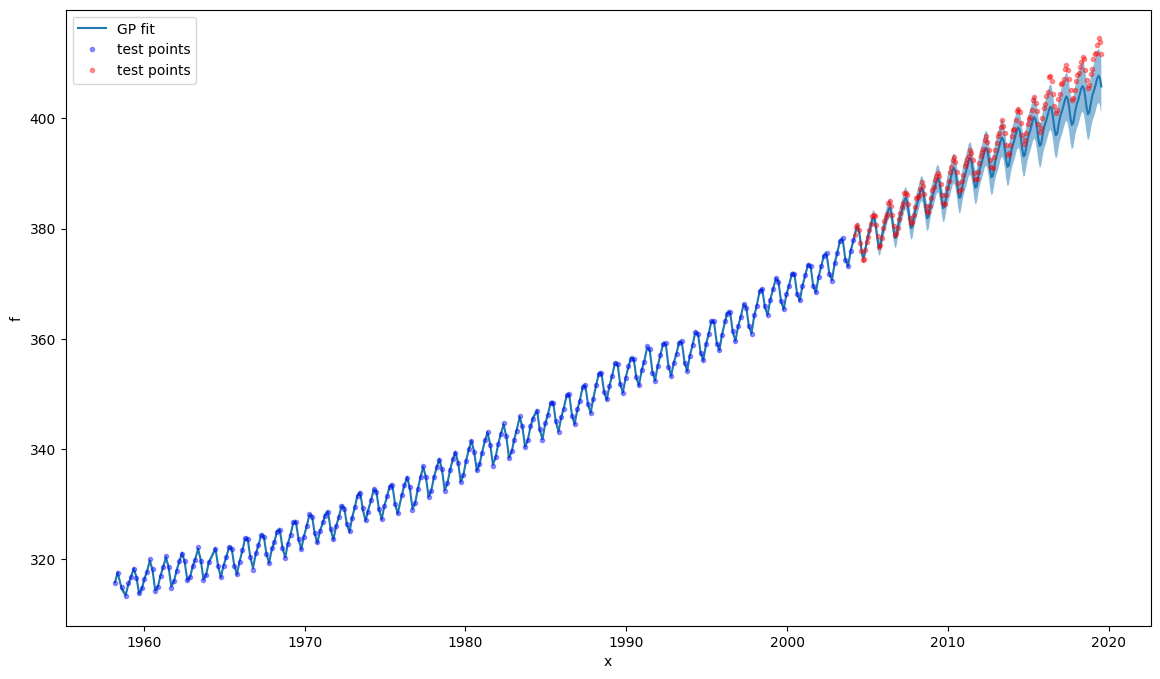

In [ ]:
mean, Cov = prediction(best_model, Xnew, noisy=True) # noisy prediction

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4, label="test points");
plt.legend()

We can see from the output of the optimiser that there are a number of different minima in the negative log-likelihood (corresponding to maxima in the likelihood), implying that there are several modes. However, it's possible to get a good fit of the function with a GP with great predictive power. You might try allowing the optimiser to run for more iterations when you have more time.

We can also look at the effects of each kernel on the GP model, which will show the features that it represents in the fit. For example, we expect the `Bias` to capture the offset, and the `Exponential` kernel to extract most of the non-linearity (that's not explained by the periodicity). We can view the effects of each of the components and the combination of them to see how they deconstruct the training data. This shows what features are being learned by which kernel.

In [ ]:
def show_component_effect(Kc_XX, K_XX_inv, Y):
    mean = Kc_XX @ K_XX_inv @ Y.squeeze(1)
    cov = Kc_XX - Kc_XX @ K_XX_inv @ Kc_XX.T
    return mean, cov

In [ ]:
K_XX = (best_model.covar_module(X) + best_model.likelihood.noise * torch.eye(X.shape[0])).to_dense()
K_XX_inv = torch.inverse(K_XX)

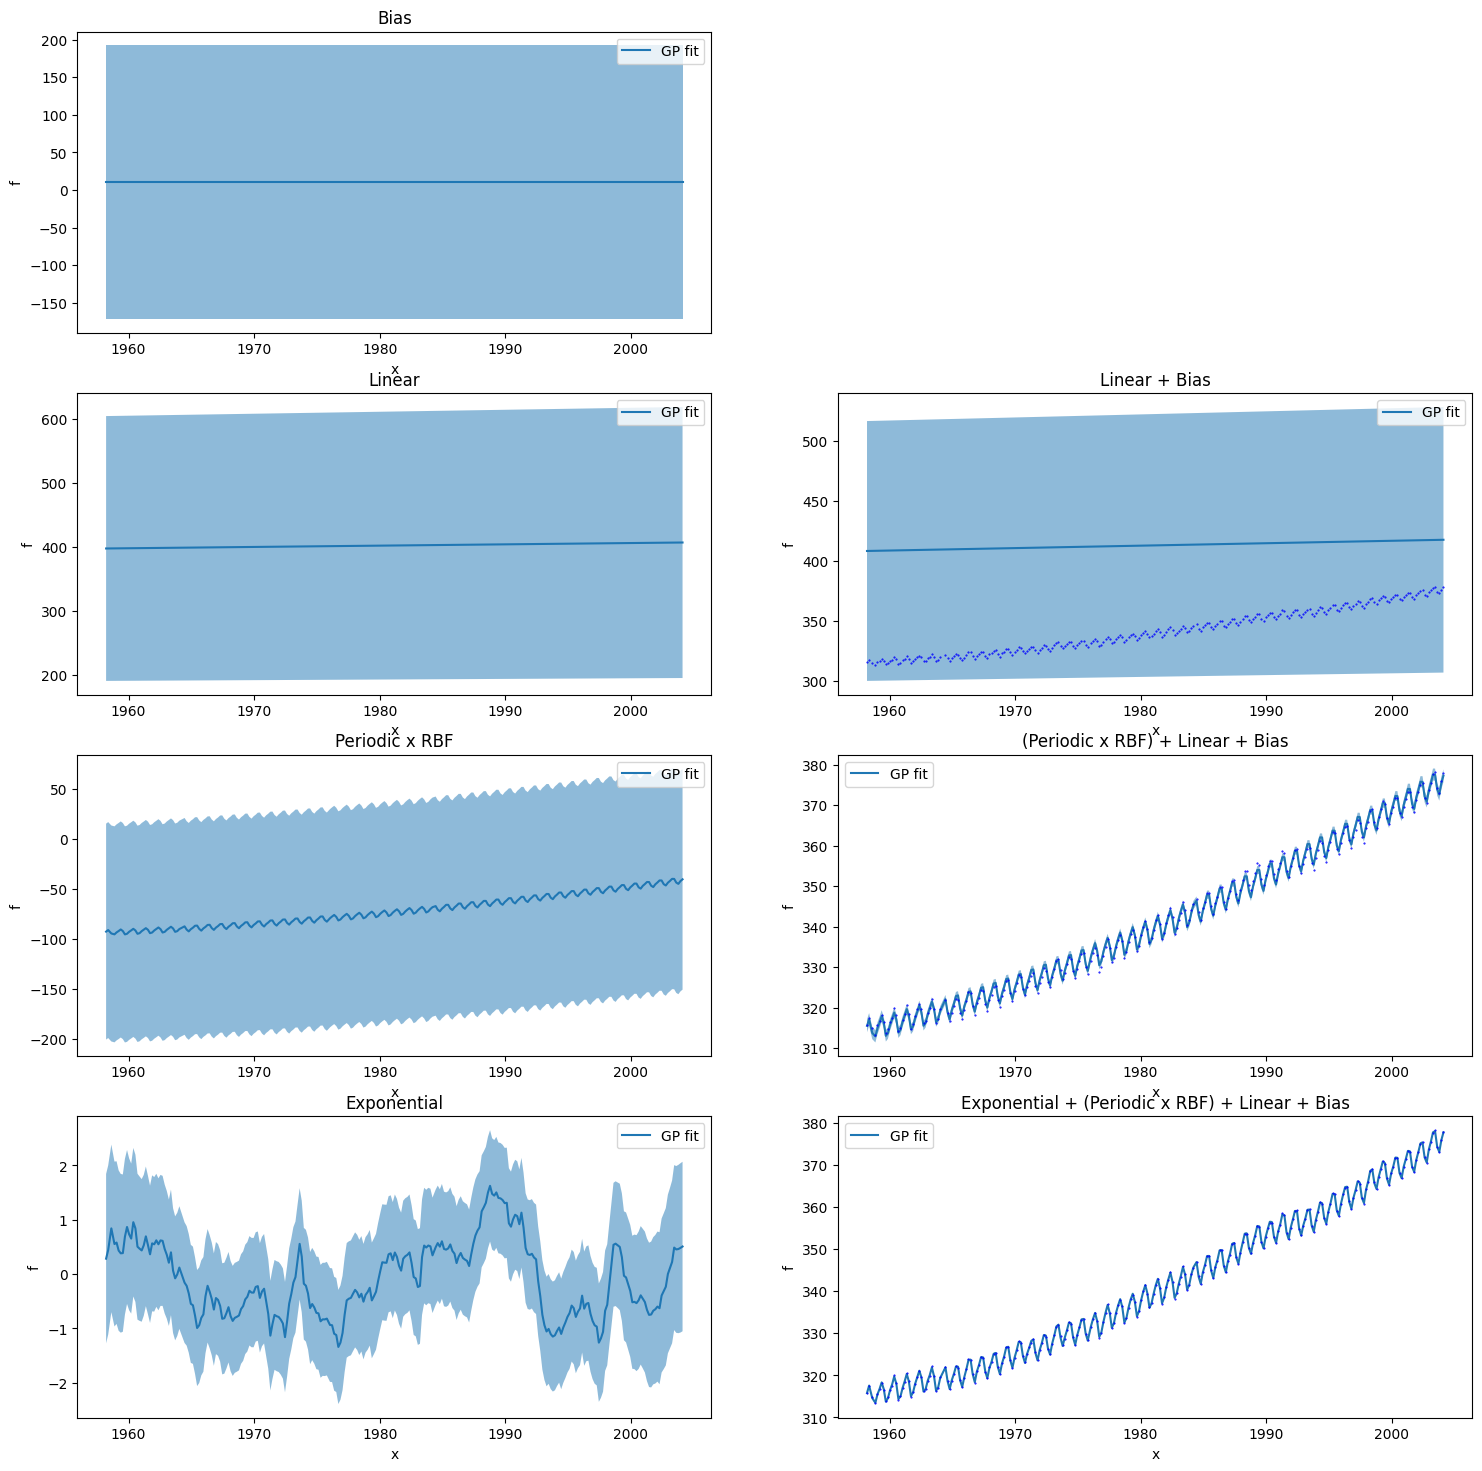

In [ ]:
# Setup figure environment (4x2 grid)
plt.figure(figsize=(18,18))

all_kernels = best_model.covar_module.kernels

# Show Bias kernel effect
plt.subplot(421)
K_bias_XX = best_model.covar_module.kernels[1](X).to_dense()
mean1, Cov1 = show_component_effect(K_bias_XX, K_XX_inv, Y)
plot_gp(X, mean1, Cov1)
plt.title("Bias")

# Show Linear kernel effect
plt.subplot(423)
K_linear_XX = best_model.covar_module.kernels[2](X).to_dense()
mean2, Cov2 = show_component_effect(K_linear_XX, K_XX_inv, Y)
plot_gp(X, mean2, Cov2)
plt.title("Linear")

# Show combination of Bias and Linear kernels
plt.subplot(424)
K_bias_plus_linear_XX = (best_model.covar_module.kernels[1](X) + best_model.covar_module.kernels[2](X)).to_dense()
mean3, Cov3 = show_component_effect(K_bias_plus_linear_XX, K_XX_inv, Y)
plot_gp(X, mean3, Cov3)
plt.plot(X, Y, ".b", ms=1.)
plt.title("Linear + Bias")

# Show modulated Periodic x RBF kernel
plt.subplot(425)
K_periodic_times_rbf_XX = best_model.covar_module.kernels[3](X).to_dense()
mean4, Cov4 = show_component_effect(K_periodic_times_rbf_XX, K_XX_inv, Y)
plot_gp(X, mean4, Cov4)
plt.title("Periodic x RBF")

# Show combination of Periodic x RBF, Bias and Linear kernels
plt.subplot(426)
K_periodic_times_rbf_plus_bias_plus_linear_XX = (best_model.covar_module.kernels[3](X) + best_model.covar_module.kernels[1](X) \
                                                  + best_model.covar_module.kernels[2](X)).to_dense()
mean5, Cov5 = show_component_effect(K_periodic_times_rbf_plus_bias_plus_linear_XX, K_XX_inv, Y)
plot_gp(X, mean5, Cov5)
plt.plot(X, Y, ".b", ms=1.)
plt.title("(Periodic x RBF) + Linear + Bias")

# Show Exponential kernel effect
plt.subplot(427)
K_exponential_XX = best_model.covar_module.kernels[0](X).to_dense()
mean6, Cov6 = show_component_effect(K_exponential_XX, K_XX_inv, Y)
plot_gp(X, mean6, Cov6)
plt.title("Exponential")

# Show combination of Periodic x RBF, Bias, Linear and Exponential kernel (this is our full GP fit !)
plt.subplot(428)
K_all_XX = best_model.covar_module(X).to_dense()
mean7, Cov7 = show_component_effect(K_all_XX, K_XX_inv, Y)
plot_gp(X, mean7, Cov7)
plt.plot(X, Y, ".b", ms=1.)
plt.title("Exponential + (Periodic x RBF) + Linear + Bias");


It's clear that while our final fit is very good, some of the kernel effects are not as clear cut as we expected. For example, much of the upward trend is captured by the periodic combination, likely due to its ability to vary non-linearly. However, we can see that, for example, the `Exponential` kernel has a clear purpose in adjusting the GP fit to the data.

How clear the differing effects of the kernels are is dependent on the random seed, and the number of optimisation restarts of the hyperparameters. However something that can be observed is that trying to embed the linear trend in the covariance function with a nonlinear periodic function is largely redundant as the periodic*rbf kernel is clearly capturing most of the upward trend. We might play around with smoother non-linear kernels, for example adding a higher order Matern than exponential (3/2 or 5/2). We can also make use of kernels not shown in this lab, such as the periodic Matern kernels.

Another option is to embed our linear trend in the mean function of our GP prior. While this is not especially common in machine learning, if we have reliable prior assumptions of the model, we can embed this explicitly. Putting a prior over the parameters of the linear mean function would keep the Bayesian approach to learning the model, but would allow us to fit periodicity to the data independent(ish) of the linear mapping.

### Exercise 7

What improvements might be made to the GP model, for example in terms  combinations of kernels and parameters, to get a better fit, especially for the prediction of our testing data?

## 8. Multiple Inputs

Typically, we will have data that is more than one-dimensional. Gaussian processes regression is scalable in dimension, and everything used above can be used with multiple inputs. The following problem is reasonably straight-forward, a simple extension of the regression problem we've used to 2-dimensional input.

Consider the toy example:
$$
    f = (x_1, x_2) \mapsto \sin(x_1)\sin(x_2)
$$
$$
    y = f(\mathbf{X}) + \epsilon, \quad \epsilon \sim \mathscr{N}(0, \sigma^2)
$$

Now, our input space is made up of two coordinates, $(x_1, x_2)$. Suppose we have some random noisy observations of the function, which are 1-dimensional in nature:

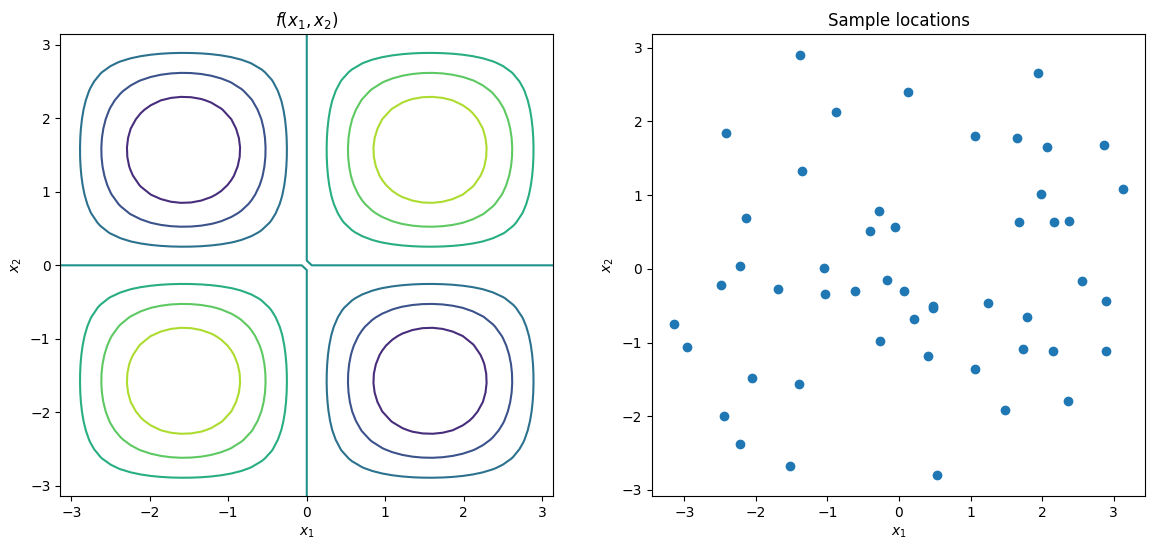

In [ ]:
# Lambda function, f, the unknown function we are trying to predict
f = lambda xi, xj: torch.sin(xi) * torch.sin(xj)

# Our test grid
[Xi, Xj] = torch.meshgrid(torch.linspace(-torch.pi, torch.pi, 50), torch.linspace(-torch.pi, torch.pi, 50))

# Number of samples [YOU CAN PLAY AROUND WITH THE NUMBER OF RANDOM SAMPLES TO SEE HOW THE FIT IS AFFECTED]
num_measurements = 50

# Random sample locations (2-D)
X_train = (torch.rand(num_measurements, 2) - 0.5) * 2. * torch.pi

# Setup plot enviornment
plt.figure(figsize=(14, 6))

plt.subplot(121)
# Show true function
plt.contour(Xi.numpy(), Xj.numpy(), f(Xi,Xj).numpy())
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("$f(x_1,x_2)$")

plt.subplot(122)
# Show sample locations
plt.plot(X_train[:,0],X_train[:,1],'o')
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Sample locations");

Our observations then are simply our sample locations propagated through $f$ with some Gaussian noise

In [ ]:
Y_train = torch.tensor([f(x1,x2) for (x1,x2) in zip(X_train[:,0], X_train[:,1])]) + 0.05 * torch.randn(X_train.shape[0])

We can fit a Gaussian process over the observations by selecting a 2-D kernel. For example, the `RBF` kernel has a 2-D (really N-D) form, so we can use this as our kernel choice.

Here, we use the same lengthscale for both the input dimensions.

In [ ]:
# initialize likelihood, fix the Gaussian noise variance, which we know
likelihood = GaussianLikelihood()
likelihood.noise = 0.05
likelihood.raw_noise.requires_grad = False

mean_module = ZeroMean()
covar_module = ScaleKernel(RBFKernel())  # gpytorch will internally handle the input dims

model = ExactGPModel(X_train, Y_train, mean_module, covar_module, likelihood)

<u>Now, we start to optimize the parameters of the model:</u>

In [ ]:
train_GP_Adam(model, num_training_iterations=200)

Iteration 50/200 - Loss: 0.031  noise: 5.000e-02
Iteration 100/200 - Loss: 0.031  noise: 5.000e-02
Iteration 150/200 - Loss: 0.031  noise: 5.000e-02
Iteration 200/200 - Loss: 0.031  noise: 5.000e-02
Final Loss: 0.031


(ExactGPModel(
   (likelihood): GaussianLikelihood(
     (noise_covar): HomoskedasticNoise(
       (raw_noise_constraint): GreaterThan(1.000E-04)
     )
   )
   (mean_module): ZeroMean()
   (covar_module): ScaleKernel(
     (base_kernel): RBFKernel(
       (raw_lengthscale_constraint): Positive()
     )
     (raw_outputscale_constraint): Positive()
   )
 ),
 0.03069495296841012)

Parameter name: likelihood.noise_covar.raw_noise,  raw_value = -2.97268,  constraint: GreaterThan(1.000E-04), actual_value: 0.05000
Parameter name: covar_module.raw_outputscale,  raw_value = -1.16072,  constraint: Positive(), actual_value: 0.27251
Parameter name: covar_module.base_kernel.raw_lengthscale,  raw_value = 1.12198,  constraint: Positive(), actual_value: 1.40387


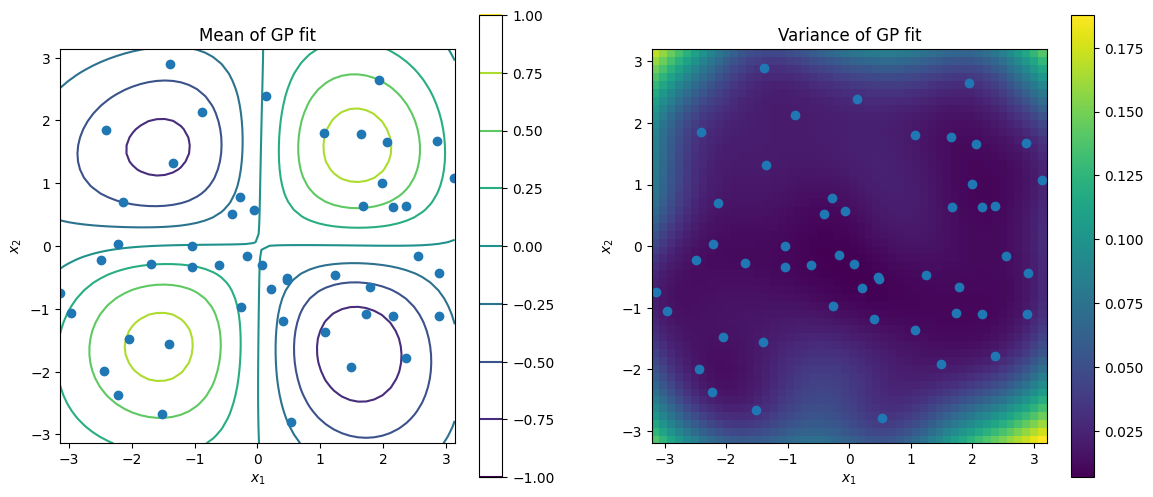

In [ ]:
Xnew = torch.vstack((Xi.ravel(), Xj.ravel())).T  # Change our input grid to list of coordinates

mean, Cov = prediction(model, Xnew)

# Setup plot environment
plt.figure(figsize=(14, 6))

# Left plot shows mean of GP fit
plt.subplot(121)

Xi_np = Xi.numpy()
Xj_np = Xj.numpy()

# Plot mean surface
plt.contour(Xi_np, Xj_np, mean.reshape(Xi_np.shape))
# Show sample locations
plt.plot(X_train[:,0], X_train[:,1], 'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Mean of GP fit"), plt.colorbar()

# Right plot shows the variance of the GP
plt.subplot(122)
# Plot variance surface
plt.pcolor(Xi_np, Xj_np, Cov.diagonal().reshape(Xi_np.shape))
# Show sample locations
plt.plot(X_train[:,0],X_train[:,1], 'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of GP fit"), plt.colorbar()

# Preview GP model parameters
show_params(model)

We can see here that the fit with the GP is generally good (this is quite a simple example, after all), and that functionally, the setup is almost identical to the 1-D case using `GPyTorch`. We can also observe from the variance surface that we have the most uncertainty where there are no samples, which matches our expectations and the observation of the power of GPs in 1-D.

Notice that in the model preview, we only have a single lengthscale that is based on both dimensions. This is because by default, the RBF kernel is isotropic, which in our case is fine. However, in reality, it is often desirable to have different parameters corresponding to different dimensions. There are two approaches to doing this in `GPyTorch`. The first is to enable different anisotropy within the kernel itself, by using the `ard_num_dims` keyword, e.g.
```
k = RBFKernel(ard_num_dims=2)
```

Alternatively, we can use kernel composition to create two kernels acting seperately on different dimensions. An alternative construction of the anisotropic RBF is to construct a kernel from two 1-D `RBF` kernels active on $x_1$ and $x_2$ respectively:
```
k = RBFKernel(active_dims=[0]) * RBFKernel(active_dims=[1])
```
<u>Kernels will use the same lengthscale for all dims by default.</u>

We can also use this construction to allow for different covariance assumptions in different dimensions. In the following example, we use an RBF to model $x_1$ and a Matérn-$\frac{3}{2}$ kernel for $x_2$:
```
k = RBFKernel(active_dims=[0]) * MaternKernel(nu=1.5, active_dims=[1])
```

In [ ]:
# initialize likelihood, fix the Gaussian noise variance, which we know
likelihood = GaussianLikelihood()
likelihood.noise = 0.05
likelihood.raw_noise.requires_grad = False

mean_module = ZeroMean()
covar_module = ScaleKernel(RBFKernel(active_dims=[0]) * MaternKernel(nu=1.5, active_dims=[1]))

model = ExactGPModel(X_train, Y_train, mean_module, covar_module, likelihood)

In [ ]:
# train the model, we only need to adjust the code of printing parameters
def train_2D_GP_ARD(model, num_training_iterations=200, lr=0.1, print_iter=50):
  X = model.train_inputs[0]
  Y = model.train_targets

  # Set the model to training mode
  model.train()

  # Set the Adam optimizer in PyTorch
  optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)  # load model's parameters

  # Marginal log likelihood for GP
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

  for i in range(num_training_iterations):
    def closure():
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(X)
      # Calculate loss and backprop gradients
      loss = - mll(output, Y)
      loss.backward()
      return loss

    # update
    optimizer.step(closure)

    # new print function for the training process
    if (i + 1) % print_iter == 0:
      loss = - mll(model(model.train_inputs[0]), model.train_targets).item()
      var = model.covar_module.outputscale.item()
      ls_rbf = model.covar_module.base_kernel.kernels[0].lengthscale.item()
      ls_matern = model.covar_module.base_kernel.kernels[1].lengthscale.item()
      noise = model.likelihood.noise.item()
      print(
        f'Iteration {i + 1}/{num_training_iterations} - Loss: {loss:.3f}  ',
        f'outputscale: {var:.3f}  ls_rbf: {ls_rbf:.3f}  ls_matern: {ls_matern:.3f} noise: {noise:.3e}'
      )


train_2D_GP_ARD(model)

Iteration 50/200 - Loss: 0.087   outputscale: 0.256  ls_rbf: 1.323  ls_matern: 1.850 noise: 5.000e-02
Iteration 100/200 - Loss: 0.087   outputscale: 0.256  ls_rbf: 1.323  ls_matern: 1.850 noise: 5.000e-02
Iteration 150/200 - Loss: 0.087   outputscale: 0.256  ls_rbf: 1.323  ls_matern: 1.850 noise: 5.000e-02
Iteration 200/200 - Loss: 0.087   outputscale: 0.256  ls_rbf: 1.323  ls_matern: 1.850 noise: 5.000e-02


<u>Or using Adam</u>

In [ ]:
def train_2D_GP_ARD(model, num_training_iterations=200, lr=1, print_iter=50):
  X = model.train_inputs[0]
  Y = model.train_targets

  model.train()

  # Set the Adam optimizer in PyTorch
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

  for i in range(num_training_iterations):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(X)
      # Calc loss and backprop gradients
      loss = -mll(output, Y)
      loss.backward()
      optimizer.step()

      # print the training process
      if (i + 1) % print_iter == 0:
        var = model.covar_module.outputscale.item()
        ls_rbf = model.covar_module.base_kernel.kernels[0].lengthscale.item()
        ls_matern = model.covar_module.base_kernel.kernels[1].lengthscale.item()
        noise = model.likelihood.noise.item()
        print(
          f'Iteration {i + 1}/{num_training_iterations} - Loss: {loss:.3f}  ',
          f'outputscale: {var:.3f}  ls_rbf: {ls_rbf:.3f}  ls_matern: {ls_matern:.3f} noise: {noise:.3e}'
        )


train_2D_GP_ARD(model)

Iteration 50/200 - Loss: 0.087   outputscale: 0.241  ls_rbf: 1.358  ls_matern: 1.864 noise: 5.000e-02
Iteration 100/200 - Loss: 0.087   outputscale: 0.256  ls_rbf: 1.323  ls_matern: 1.850 noise: 5.000e-02
Iteration 150/200 - Loss: 0.087   outputscale: 0.256  ls_rbf: 1.323  ls_matern: 1.849 noise: 5.000e-02
Iteration 200/200 - Loss: 0.087   outputscale: 0.256  ls_rbf: 1.323  ls_matern: 1.850 noise: 5.000e-02


Parameter name: likelihood.noise_covar.raw_noise,  raw_value = -2.97268,  constraint: GreaterThan(1.000E-04), actual_value: 0.05000
Parameter name: covar_module.raw_outputscale,  raw_value = -1.23268,  constraint: Positive(), actual_value: 0.25581
Parameter name: covar_module.base_kernel.kernels.0.raw_lengthscale,  raw_value = 1.01381,  constraint: Positive(), actual_value: 1.32337
Parameter name: covar_module.base_kernel.kernels.1.raw_lengthscale,  raw_value = 1.67849,  constraint: Positive(), actual_value: 1.84963


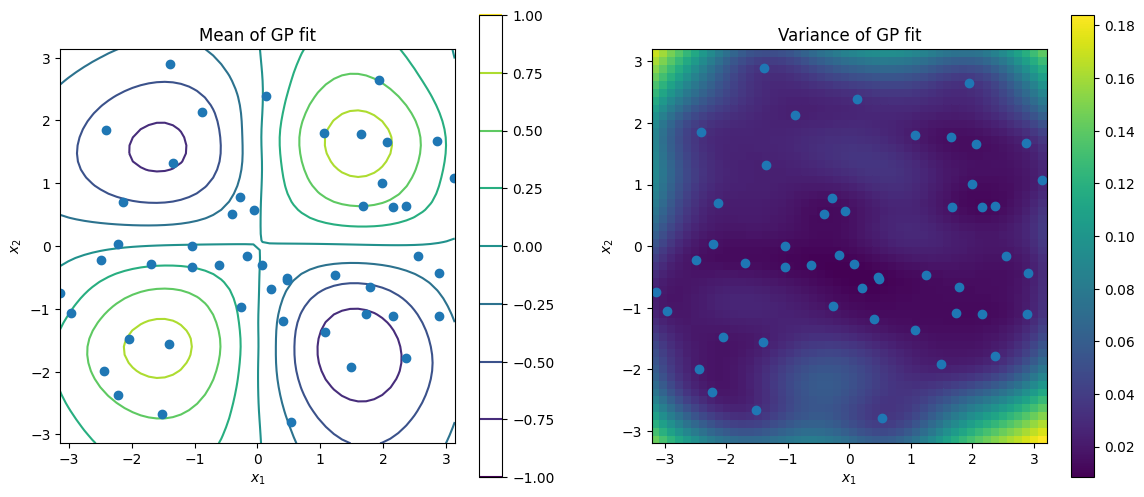

In [ ]:
Xnew = torch.vstack((Xi.ravel(), Xj.ravel())).T  # Change our input grid to list of coordinates

mean, Cov = prediction(model, Xnew)

# Setup plot environment
plt.figure(figsize=(14, 6))

# Left plot shows mean of GP fit
plt.subplot(121)

Xi_np = Xi.numpy()
Xj_np = Xj.numpy()


# Plot mean surface
plt.contour(Xi_np, Xj_np, mean.reshape(Xi_np.shape))
# Show sample locations
plt.plot(X_train[:,0], X_train[:,1], 'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Mean of GP fit"), plt.colorbar()

# Right plot shows the variance of the GP
plt.subplot(122)
# Plot variance surface
plt.pcolor(Xi_np, Xj_np, Cov.diagonal().reshape(Xi_np.shape))
# Show sample locations
plt.plot(X_train[:,0],X_train[:,1], 'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of GP fit"), plt.colorbar()

# Preview GP model parameters
show_params(model)

---

## Footnote

Using Gaussian processes for machine learning gives you a powerful tool for learning latent functions in a Bayesian fashion, especially with a low number of observations. However, full GP regression can be quite time consuming, given it scales $\mathcal{O}(n^3)$ with the number of training points, $n$. There are methods for dealing with this: for example, sparse approximation or representing the regression problem as a state-space model. Each of these comes with their own assumptions and drawbacks.

When using GPs in a computational setting, there are a wide range of tools that can be used depending on your preference of programming language and libraries. Some other libraries that are commonly used for Gaussian processes include:</u>

| Name     | Language | Comments |
|---------|-----------|----------|
| `GPy`     | Python | One of the earliest Python frameworks for Gaussian processes |
| `GPML`    | MATLAB | Examples and code used in Rasmussen & Williams GPML book |
| `GPstuff` | MATLAB, Octave, R | A MATLAB library with a wide arrange of inference methods, including HMC |
| `GPflow`  | Python | GP library built on `TensorFlow`, similar notation to `GPy` |
| `Stan`    | R, Python, others | Probabilistic programming using MCMC that can be easily be used to model GPs |

### Credit

This notebook is adapted from notebooks by [Rich Wilkinson](https://rich-d-wilkinson.github.io/) and [Neil Lawrence](http://inverseprobability.com/).